# Testing non parametric functions

In [ ]:
# Import Libraries - Enhanced for Statistical Analysis
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv

from scipy.optimize import minimize
from scipy.special import expit
import numpy as np
import statsmodels.api as sm

from sklearn.metrics import roc_curve, auc


from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')


# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Load environment variables from .env file
load_dotenv()

# Set Up Database Connection from environment variables
DB_CONFIG = {
    "dbname": os.getenv("DB_NAME"),
    "user": os.getenv("DB_USER"),
    "password": os.getenv("DB_PASSWORD"),
    "host": os.getenv("DB_HOST"),
    "port": os.getenv("DB_PORT")
}

In [2]:


# Ensure we have a fresh connection
try:
    conn = psycopg2.connect(**DB_CONFIG)
    print("✅ Database connection established")
except Exception as e:
    print(f"❌ Connection error: {e}")


print("📊 Helper functions defined successfully!")

✅ Database connection established
📊 Helper functions defined successfully!


In [3]:
# Query for detailed round outcomes

query_detailed = """
WITH round_equipment AS (
    SELECT 
        r.id,
        r.match_id,
        r.id_demo_exports,
        r.round_num,
        r.ct_winner,
        r.team1_winner,
        r.is_ct_t1,
        r.round_end_reason,
        -- CT team equipment
        SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) as ct_equipment,
        -- T team equipment
        SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) as t_equipment,
        r.t1_score_end,
        r.t2_score_end,
        r.t1_score_start,
        r.t2_score_start,
        hmi.team_1_id,
        hmi.team_2_id,
        hmi.event_id
    FROM rounds_ed r
    JOIN player_round_ed pr ON r.id = pr.round_id
    LEFT JOIN hltv_match_info hmi ON r.match_id = hmi.match_id
    WHERE pr.eq_val_fte > 0
    GROUP BY 1,2,3,4,5,6,7,8, 11,12,13, 14,15,16,17
),
bomb_planted AS (
    SELECT 
        round_id,
        CASE WHEN COUNT(*) > 0 THEN 1 ELSE 0 END as bomb_planted
    FROM bomb_events_round_ed
    WHERE bomb_event_type = 0
    GROUP BY round_id
),
round_survivors AS (
    SELECT 
        r.id as round_id,
        r.is_ct_t1,
        -- Count total players per team (5 players each)
        -- CT survivors = 5 - (deaths of CT players)
        5 - COUNT(DISTINCT CASE 
            WHEN (r.is_ct_t1 = (pv.team = 1)) THEN k.victim_hltv_id 
        END) as ct_survivors,
        -- T survivors = 5 - (deaths of T players)
        5 - COUNT(DISTINCT CASE 
            WHEN (r.is_ct_t1 != (pv.team = 1)) THEN k.victim_hltv_id 
        END) as t_survivors
    FROM rounds_ed r
    LEFT JOIN kills_round_ed k ON r.id = k.round_id
    LEFT JOIN player_round_ed pv ON k.victim_hltv_id = pv.player_id AND k.round_id = pv.round_id and pv.player_id != 0
    GROUP BY 1,2
),
saved_equipment AS (
    SELECT 
        r.id as round_id,
        r.is_ct_t1,
        -- CT team saved equipment from player_economy_ed joined with player_round_ed
        SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN COALESCE(pe.saved_eq_val, 0) ELSE 0 END) as ct_saved_equipment,
        SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN COALESCE(pe.starting_eq_val, 0) ELSE 0 END) as ct_starting_equipment,
        -- T team saved equipment from player_economy_ed joined with player_round_ed
        SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN COALESCE(pe.saved_eq_val, 0) ELSE 0 END) as t_saved_equipment,
        SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN COALESCE(pe.starting_eq_val, 0) ELSE 0 END) as t_starting_equipment
    FROM rounds_ed r
    JOIN player_economy_ed pe ON r.id = pe.round_id
    JOIN player_round_ed pr ON r.id = pr.round_id AND pe.player_id = pr.player_id and pr.player_id != 0
    GROUP BY 1,2
),
team_money AS (
    SELECT 
        r.id as round_id,
        r.is_ct_t1,
        -- CT team player money (money_earned + money_earned_re) joined with player_round_ed
        CASE WHEN COUNT(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) AND (pe.money_earned = 0 OR pe.money_earned IS NULL) THEN 1 END) > 0 
            OR SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN 1 ELSE 0 END) = 0
            THEN NULL 
            ELSE SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN pe.money_earned ELSE 0 END) 
        END as ct_money_earned,
        -- CT team player money at start 
        CASE WHEN COUNT(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) AND (pe.money_start = 0 OR pe.money_start IS NULL) THEN 1 END) > 0 
            OR SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN 1 ELSE 0 END) = 0
            THEN NULL 
            ELSE SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN pe.money_start ELSE 0 END) 
        END as ct_money_start,
        -- CT team player money spent (no zero check)
        CASE WHEN COUNT(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) AND pe.money_spent IS NULL THEN 1 END) > 0 
            THEN NULL 
            ELSE SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN pe.money_spent ELSE 0 END) 
        END as ct_money_spent,
        -- T team player money (money_earned + money_earned_re) joined with player_round_ed
        CASE WHEN COUNT(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) AND (pe.money_earned = 0 OR pe.money_earned IS NULL) THEN 1 END) > 0 
            OR SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN 1 ELSE 0 END) = 0
            THEN NULL 
            ELSE SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN pe.money_earned ELSE 0 END) 
        END as t_money_earned,
        -- T team player money at start 
        CASE WHEN COUNT(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) AND (pe.money_start = 0 OR pe.money_start IS NULL) THEN 1 END) > 0 
            OR SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN 1 ELSE 0 END) = 0
            THEN NULL 
            ELSE SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN pe.money_start ELSE 0 END) 
        END as t_money_start,
        -- T team player money spent (no zero check)
        CASE WHEN COUNT(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) AND pe.money_spent IS NULL THEN 1 END) > 0 
            THEN NULL 
            ELSE SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN pe.money_spent ELSE 0 END) 
        END as t_money_spent
    FROM rounds_ed r
    JOIN player_economy_ed pe ON r.id = pe.round_id
    JOIN player_round_ed pr ON r.id = pr.round_id AND pe.player_id = pr.player_id and pr.player_id != 0
    GROUP BY 1,2
),
ranked_data AS (
    SELECT 
        trd.id,
        trd.id_demo_exports,
        trd.round_num,
        trd.team1_winner,
        -- Team 1 metrics
        COALESCE(CAST(het1.rank_during AS INTEGER), 999) as t1_rank,
        -- Team 2 metrics
        COALESCE(CAST(het2.rank_during AS INTEGER), 999) as t2_rank
    FROM round_equipment trd
    LEFT JOIN hltv_events_teams het1 ON het1.team_id = trd.team_1_id AND het1.event_id = trd.event_id
    LEFT JOIN hltv_events_teams het2 ON het2.team_id = trd.team_2_id AND het2.event_id = trd.event_id
),
previous_round_stats AS (
    SELECT 
        r.id as round_id,
        r.id_demo_exports,
        r.round_num,
        COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 = (pr_prev.team = 1)) THEN COALESCE(pr_prev.kills, 0) ELSE 0 END), 0) as ct_prev_kills,
        COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 != (pr_prev.team = 1)) THEN COALESCE(pr_prev.kills, 0) ELSE 0 END), 0) as t_prev_kills,
        COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 = (pr_prev.team = 1)) THEN COALESCE(pr_prev.assists, 0) ELSE 0 END), 0) as ct_prev_assists,
        COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 != (pr_prev.team = 1)) THEN COALESCE(pr_prev.assists, 0) ELSE 0 END), 0) as t_prev_assists,
        COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 = (pr_prev.team = 1)) THEN COALESCE(pr_prev.deaths, 0) ELSE 0 END), 0) as ct_prev_deaths,
        COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 != (pr_prev.team = 1)) THEN COALESCE(pr_prev.deaths, 0) ELSE 0 END), 0) as t_prev_deaths
    FROM rounds_ed r
    LEFT JOIN rounds_ed r_prev ON r.id_demo_exports = r_prev.id_demo_exports 
        AND r_prev.round_num = r.round_num - 1 
        AND r.round_num > 1
    LEFT JOIN player_round_ed pr_prev ON r_prev.id = pr_prev.round_id AND pr_prev.player_id != 0
    GROUP BY 1,2,3
),
streaks as (
    SELECT 
    rse.round_id,
    rse.id_demo_exports,
    rse.round_num,
    rse.t1_win_streak,
    rse.t1_loss_streak,
    rse.t1_win_streak_cons,
    rse.t1_loss_streak_cons,
    rse.t2_win_streak,
    rse.t2_loss_streak,
    rse.t2_win_streak_cons,
    rse.t2_loss_streak_cons,
    COALESCE(rse.t1_win_streak, 0) as t1_win_streak_prev,
    COALESCE(rse.t1_loss_streak, 0) as t1_loss_streak_prev,
    COALESCE(rse.t1_win_streak_cons, 0) as t1_win_streak_cons_prev ,
    COALESCE(rse.t1_loss_streak_cons, 0) as t1_loss_streak_cons_prev ,
    COALESCE(rse.t2_win_streak, 0) as t2_win_streak_prev,
    COALESCE(rse.t2_loss_streak, 0) as t2_loss_streak_prev,
    COALESCE(rse.t2_win_streak_cons, 0) as t2_win_streak_cons_prev,
    COALESCE(rse.t2_loss_streak_cons, 0) as t2_loss_streak_cons_prev
    FROM round_streaks_ed rse
    -- loockback part
    LEFT JOIN round_streaks_ed rse_prev ON rse.id_demo_exports = rse_prev.id_demo_exports 
        AND rse_prev.round_num = rse.round_num - 1 
        AND rse.round_num > 1
)

SELECT 
    re.*,
    -- Add bomb planted status
    COALESCE(bp.bomb_planted, 0) as bomb_planted,
    -- Add survivor counts from round_survivors CTE
    rs.ct_survivors,
    rs.t_survivors,
    -- Higher and lower equipment
    CASE 
        WHEN re.ct_equipment > re.t_equipment THEN re.ct_equipment
        ELSE re.t_equipment
    END as higher_equipment,
    CASE 
        WHEN re.ct_equipment <= re.t_equipment THEN re.ct_equipment
        ELSE re.t_equipment
    END as lower_equipment,
    -- Did higher equipment team win?
    CASE 
        WHEN (re.ct_equipment > re.t_equipment AND re.ct_winner)
        OR (re.ct_equipment < re.t_equipment AND NOT re.ct_winner)
        THEN 1
        ELSE 0
    END as higher_eq_won,
    -- Winner's survivors (only from is_alive_re)
    CASE 
        WHEN re.ct_winner THEN rs.ct_survivors
        ELSE rs.t_survivors
    END as winner_survivors,
    -- Winner's saved equipment (from player_economy_ed.saved_eq_val)
    CASE 
        WHEN re.ct_winner THEN se.ct_saved_equipment
        ELSE se.t_saved_equipment
    END as winner_saved_equipment,
    -- CT and T saved equipment 
    se.ct_saved_equipment,
    se.ct_starting_equipment,
    se.t_saved_equipment,
    se.t_starting_equipment,
    -- All money columns for analysis
    tm.ct_money_earned,
    tm.ct_money_start,
    tm.ct_money_spent,
    tm.t_money_earned,
    tm.t_money_start,
    tm.t_money_spent,
    -- Previous round stats
    prs.ct_prev_kills,
    prs.t_prev_kills,
    prs.ct_prev_assists,
    prs.t_prev_assists,
    prs.ct_prev_deaths,
    prs.t_prev_deaths,
    -- Ranked data
    rd.t1_rank,
    rd.t2_rank,
    -- streaks data
    st.t1_win_streak,
    st.t1_loss_streak,
    st.t1_win_streak_cons,
    st.t1_loss_streak_cons,
    st.t2_win_streak,
    st.t2_loss_streak,
    st.t2_win_streak_cons,
    st.t2_loss_streak_cons,
    st.t1_win_streak_prev, 
    st.t1_loss_streak_prev, 
    st.t1_win_streak_cons_prev, 
    st.t1_loss_streak_cons_prev, 
    st.t2_win_streak_prev, 
    st.t2_loss_streak_prev, 
    st.t2_win_streak_cons_prev, 
    st.t2_loss_streak_cons_prev
FROM round_equipment re
LEFT JOIN bomb_planted bp ON re.id = bp.round_id
LEFT JOIN round_survivors rs ON re.id = rs.round_id
LEFT JOIN saved_equipment se ON re.id = se.round_id
LEFT JOIN previous_round_stats prs ON re.id = prs.round_id
LEFT JOIN team_money tm ON re.id = tm.round_id
LEFT JOIN ranked_data rd ON re.id = rd.id
LEFT JOIN streaks st ON re.id = st.round_id
WHERE re.ct_equipment > 0 AND re.t_equipment > 0 
ORDER BY re.id_demo_exports, re.round_num
"""

print("📊 Fetching detailed round data...")
detailed_df = pd.read_sql_query(query_detailed, conn)
print(f"✅ Loaded {len(detailed_df):,} rounds with complete data")
print()

# Combine round end reasons 12 and 7
print("🔹 Pre-processing: Combining round end reasons 12 and 7")
detailed_df['round_end_reason'] = detailed_df['round_end_reason'].replace({12: 7})
print(f"   Round end reasons 12 merged into 7")
print()

# Recode round end reasons: 1→1, 9→2, 7→3, 8→4
print("🔹 Recoding round end reasons")
original_count = len(detailed_df)
print(f"   Original distribution:")
for old_code in [1, 7, 8, 9]:
    count = (detailed_df['round_end_reason'] == old_code).sum()
    pct = count / len(detailed_df) * 100 if len(detailed_df) > 0 else 0
    print(f"      Reason {old_code}: {count:,} rounds ({pct:.2f}%)")

detailed_df['round_end_reason'] = detailed_df['round_end_reason'].replace({
    1: 1,  # T Win (Target Bombed) - no change
    9: 2,  # T Win (Elimination) - 9 → 2
    7: 3,  # CT Win (Defuse) - 7 → 3
    8: 4,  # CT Win (Elimination) - 8 → 4
})

print(f"   New distribution:")
for new_code in [1, 2, 3, 4]:
    count = (detailed_df['round_end_reason'] == new_code).sum()
    pct = count / len(detailed_df) * 100 if len(detailed_df) > 0 else 0
    print(f"      Reason {new_code}: {count:,} rounds ({pct:.2f}%)")
print()



📊 Fetching detailed round data...
✅ Loaded 2,601,592 rounds with complete data

🔹 Pre-processing: Combining round end reasons 12 and 7
   Round end reasons 12 merged into 7

🔹 Recoding round end reasons
   Original distribution:
      Reason 1: 407,446 rounds (15.66%)
      Reason 7: 405,067 rounds (15.57%)
      Reason 8: 934,538 rounds (35.92%)
      Reason 9: 854,541 rounds (32.85%)
   New distribution:
      Reason 1: 407,446 rounds (15.66%)
      Reason 2: 854,541 rounds (32.85%)
      Reason 3: 405,067 rounds (15.57%)
      Reason 4: 934,538 rounds (35.92%)



# Export of the original Query for Replication in csv format
If the notebook is to be replicated outside of the DB environment, use the provided CSV from this point on

In [4]:
# Export the detailed_df dataframe to CSV
from datetime import datetime

# Create filename with current date
export_date = datetime.now().strftime('%Y%m%d')
csv_filename = f'non_parametric_methods_{export_date}.csv'

# Export to CSV
detailed_df.to_csv(csv_filename, index=False)

print(f"✅ Data exported to: {csv_filename}")
print(f"   Rows: {len(detailed_df):,}")
print(f"   Columns: {len(detailed_df.columns)}")
print(f"   Column names: {', '.join(detailed_df.columns.tolist())}")

✅ Data exported to: non_parametric_methods_20260213.csv
   Rows: 2,601,592
   Columns: 59
   Column names: id, match_id, id_demo_exports, round_num, ct_winner, team1_winner, is_ct_t1, round_end_reason, ct_equipment, t_equipment, t1_score_end, t2_score_end, t1_score_start, t2_score_start, team_1_id, team_2_id, event_id, bomb_planted, ct_survivors, t_survivors, higher_equipment, lower_equipment, higher_eq_won, winner_survivors, winner_saved_equipment, ct_saved_equipment, ct_starting_equipment, t_saved_equipment, t_starting_equipment, ct_money_earned, ct_money_start, ct_money_spent, t_money_earned, t_money_start, t_money_spent, ct_prev_kills, t_prev_kills, ct_prev_assists, t_prev_assists, ct_prev_deaths, t_prev_deaths, t1_rank, t2_rank, t1_win_streak, t1_loss_streak, t1_win_streak_cons, t1_loss_streak_cons, t2_win_streak, t2_loss_streak, t2_win_streak_cons, t2_loss_streak_cons, t1_win_streak_prev, t1_loss_streak_prev, t1_win_streak_cons_prev, t1_loss_streak_cons_prev, t2_win_streak_prev, 

In [5]:
# Uncomment the following lines to import the CSV file instead of querying the database
# csv_filename = f'YOUR FILE NAME HERE.csv'
# detailed_df = pd.read_csv(csv_filename)

In [6]:


# Filter out inconsistent data
# Reason 2 (T Win Elimination - was 9) should have CT survivors = 0
filtered_9 = (detailed_df['round_end_reason'] == 2) & (detailed_df['ct_survivors'] > 0)

# Find last round of each game
last_round_per_game = detailed_df.groupby('id_demo_exports')['round_num'].max()
is_last_round = detailed_df['round_num'] == detailed_df['id_demo_exports'].map(last_round_per_game)

# Separate last rounds from others
is_last_round_issue = filtered_9 & is_last_round
is_other_issue = filtered_9 & ~is_last_round

reason_9_issues = detailed_df[filtered_9]
print(f"🔹 Filtering inconsistent Reason 2 (T Win Elimination) rounds:")
print(f"   Found {len(reason_9_issues):,} rounds where Reason 2 occurred but CT had survivors > 0")

# Correct ct_survivors to 0 for last round inconsistencies, this can happen as the parser sometimes does not receive the death of the last player
#before the demo is ended
num_corrected = is_last_round_issue.sum()
if num_corrected > 0:
    detailed_df.loc[is_last_round_issue, 'ct_survivors'] = 0
    print(f"   Corrected ct_survivors to 0 for {num_corrected:,} last round inconsistencies")

# Filter out other inconsistencies
before = len(detailed_df)
detailed_df = detailed_df[~is_other_issue]
total_filtered = before - len(detailed_df)

print(f"   Removed: {total_filtered:,} rounds (non-last-round inconsistencies)")
print(f"   Remaining: {len(detailed_df):,} rounds")
print()
print("✅ Data quality filtering complete")

🔹 Filtering inconsistent Reason 2 (T Win Elimination) rounds:
   Found 2,821 rounds where Reason 2 occurred but CT had survivors > 0
   Corrected ct_survivors to 0 for 51 last round inconsistencies
   Removed: 2,770 rounds (non-last-round inconsistencies)
   Remaining: 2,598,822 rounds

✅ Data quality filtering complete


In [7]:
#transforming rank data for ct/t side

detailed_df['ct_rank'] = detailed_df[detailed_df['is_ct_t1'] == 1]['t1_rank'].combine_first(
    detailed_df[detailed_df['is_ct_t1'] == 0]['t2_rank']
)

detailed_df['t_rank'] = detailed_df[detailed_df['is_ct_t1'] == 0]['t1_rank'].combine_first(
    detailed_df[detailed_df['is_ct_t1'] == 1]['t2_rank']
)

In [8]:
detailed_df['ct_investment_ratio'] = detailed_df['ct_equipment'] / (detailed_df['ct_equipment'] + detailed_df['t_equipment'])

# Filter outliers: keep 99% interval (0.5% to 99.5% percentiles)
q_low_ratio = detailed_df['ct_investment_ratio'].quantile(0.005)
q_high_ratio = detailed_df['ct_investment_ratio'].quantile(0.995)
df_filtered_ratio = detailed_df[(detailed_df['ct_investment_ratio'] >= q_low_ratio) & (detailed_df['ct_investment_ratio'] <= q_high_ratio)]

In [9]:
test_size_global = 0.3
random_state_global = 42

In [10]:
#TODO: add CSV export for the data

# The Data Science/ Data Engineering part


CT INVESTMENT RATIO DISTRIBUTION

Normality Test (Shapiro-Wilk on 5000 sample):
  Original Data:  W=0.9427, p=0.000000 (Non-Normal)
  Filtered Data:  W=0.9427, p=0.000000 (Non-Normal)



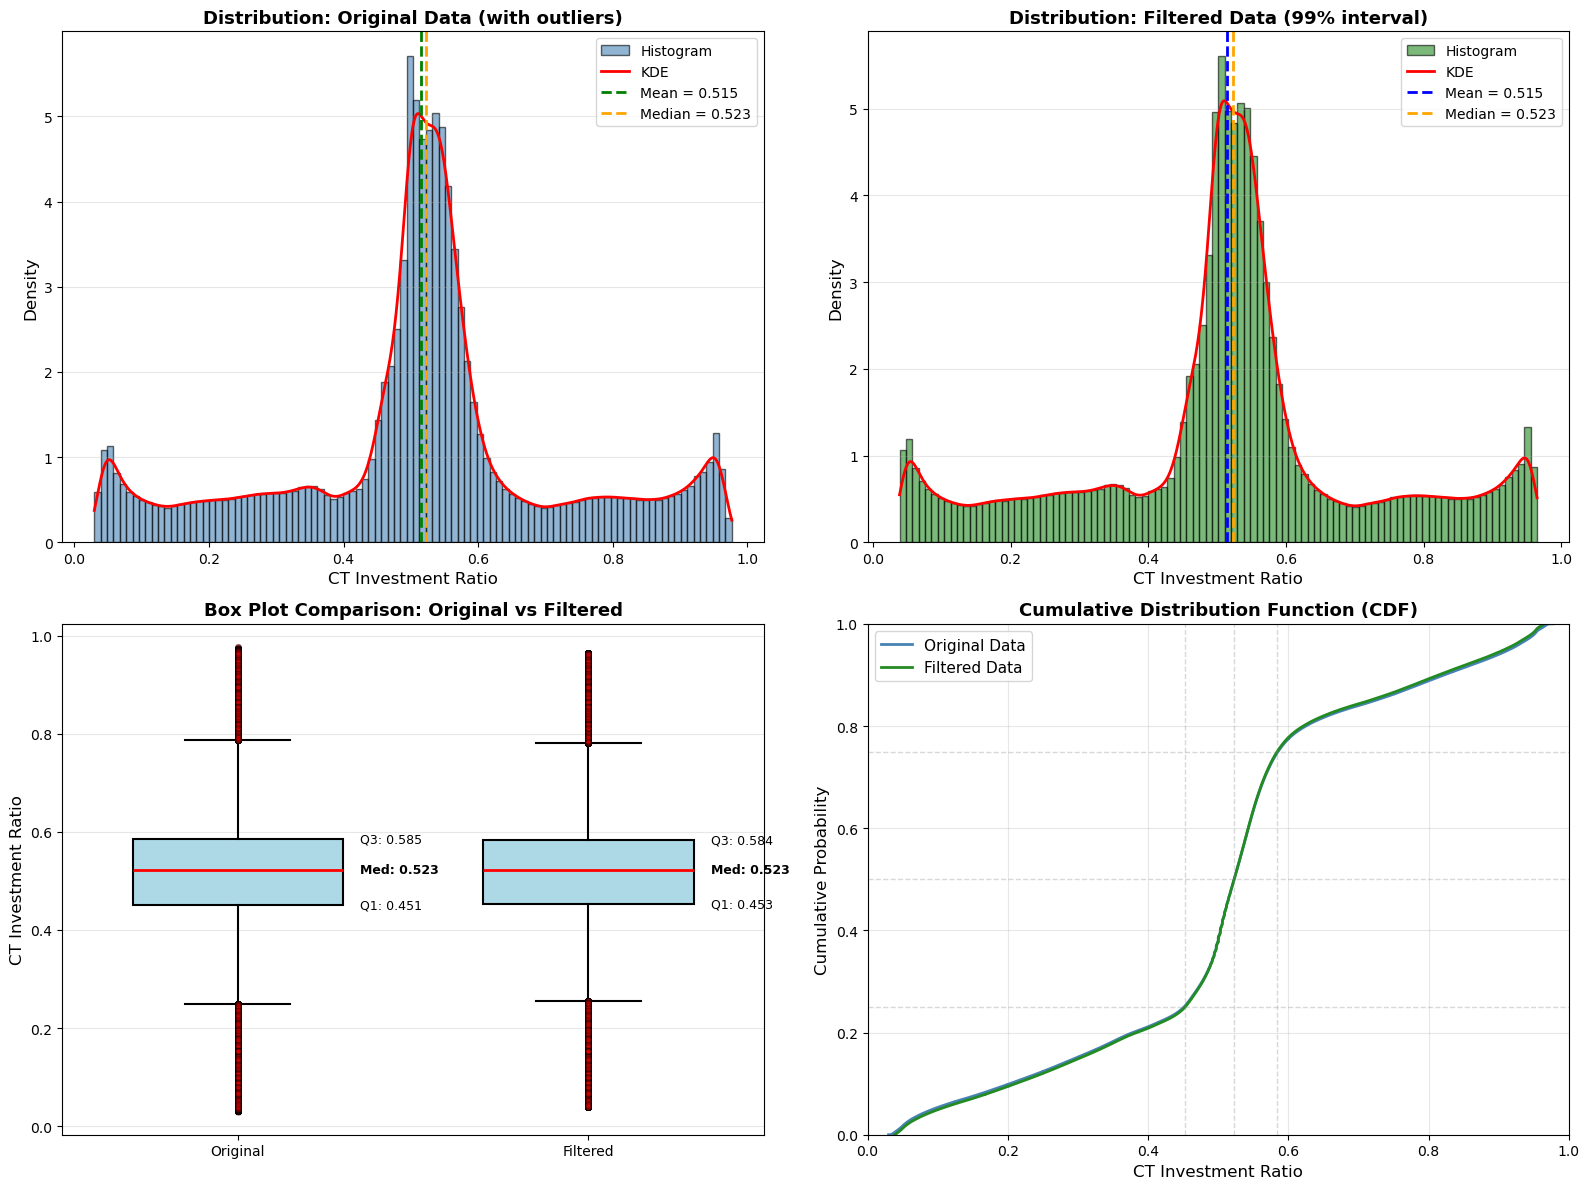

✅ Distribution Analysis Complete!


In [11]:
# ============================================================================
# DISTRIBUTION ANALYSIS: CT INVESTMENT RATIO
# ============================================================================

print("="*80)
print("CT INVESTMENT RATIO DISTRIBUTION")
print("="*80)
print()

# Test for normality
from scipy import stats
statistic_orig, p_value_orig = stats.shapiro(detailed_df['ct_investment_ratio'].sample(min(5000000, len(detailed_df)), random_state=42))
statistic_filt, p_value_filt = stats.shapiro(df_filtered_ratio['ct_investment_ratio'].sample(min(5000000, len(df_filtered_ratio)), random_state=42))

print("Normality Test (Shapiro-Wilk on 5000 sample):")
print(f"  Original Data:  W={statistic_orig:.4f}, p={p_value_orig:.6f} {'(Normal)' if p_value_orig > 0.05 else '(Non-Normal)'}")
print(f"  Filtered Data:  W={statistic_filt:.4f}, p={p_value_filt:.6f} {'(Normal)' if p_value_filt > 0.05 else '(Non-Normal)'}")
print()


# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Histogram with KDE overlay (Original Data)
ax = axes[0, 0]
ax.hist(detailed_df['ct_investment_ratio'], bins=100, density=True, alpha=0.6, color='steelblue', edgecolor='black', label='Histogram')
from scipy.stats import gaussian_kde
kde_orig = gaussian_kde(detailed_df['ct_investment_ratio'])
x_range = np.linspace(detailed_df['ct_investment_ratio'].min(), detailed_df['ct_investment_ratio'].max(), 1000)
ax.plot(x_range, kde_orig(x_range), 'r-', linewidth=2, label='KDE')
ax.axvline(detailed_df['ct_investment_ratio'].mean(), color='green', linestyle='--', linewidth=2, label=f'Mean = {detailed_df["ct_investment_ratio"].mean():.3f}')
ax.axvline(detailed_df['ct_investment_ratio'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median = {detailed_df["ct_investment_ratio"].median():.3f}')
ax.set_xlabel('CT Investment Ratio', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Distribution: Original Data (with outliers)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3, axis='y')

# Plot 2: Histogram with KDE overlay (Filtered Data)
ax = axes[0, 1]
ax.hist(df_filtered_ratio['ct_investment_ratio'], bins=100, density=True, alpha=0.6, color='forestgreen', edgecolor='black', label='Histogram')
kde_filt = gaussian_kde(df_filtered_ratio['ct_investment_ratio'])
x_range_filt = np.linspace(df_filtered_ratio['ct_investment_ratio'].min(), df_filtered_ratio['ct_investment_ratio'].max(), 1000)
ax.plot(x_range_filt, kde_filt(x_range_filt), 'r-', linewidth=2, label='KDE')
ax.axvline(df_filtered_ratio['ct_investment_ratio'].mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean = {df_filtered_ratio["ct_investment_ratio"].mean():.3f}')
ax.axvline(df_filtered_ratio['ct_investment_ratio'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median = {df_filtered_ratio["ct_investment_ratio"].median():.3f}')
ax.set_xlabel('CT Investment Ratio', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Distribution: Filtered Data (99% interval)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3, axis='y')

# Plot 3: Box Plot Comparison
ax = axes[1, 0]
box_data = [detailed_df['ct_investment_ratio'], df_filtered_ratio['ct_investment_ratio']]
bp = ax.boxplot(box_data, labels=['Original', 'Filtered'], patch_artist=True, widths=0.6,
                medianprops=dict(color='red', linewidth=2),
                boxprops=dict(facecolor='lightblue', edgecolor='black', linewidth=1.5),
                whiskerprops=dict(color='black', linewidth=1.5),
                capprops=dict(color='black', linewidth=1.5),
                flierprops=dict(marker='o', markerfacecolor='red', markersize=4, alpha=0.3))
ax.set_ylabel('CT Investment Ratio', fontsize=12)
ax.set_title('Box Plot Comparison: Original vs Filtered', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3, axis='y')

# Add summary statistics on the plot
for i, data in enumerate(box_data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    median = data.median()
    ax.text(i+1.35, q1, f'Q1: {q1:.3f}', fontsize=9, va='center')
    ax.text(i+1.35, median, f'Med: {median:.3f}', fontsize=9, va='center', fontweight='bold')
    ax.text(i+1.35, q3, f'Q3: {q3:.3f}', fontsize=9, va='center')

# Plot 4: Cumulative Distribution Function (CDF)
ax = axes[1, 1]
sorted_orig = np.sort(detailed_df['ct_investment_ratio'])
cdf_orig = np.arange(1, len(sorted_orig)+1) / len(sorted_orig)
ax.plot(sorted_orig, cdf_orig, linewidth=2, label='Original Data', color='steelblue')

sorted_filt = np.sort(df_filtered_ratio['ct_investment_ratio'])
cdf_filt = np.arange(1, len(sorted_filt)+1) / len(sorted_filt)
ax.plot(sorted_filt, cdf_filt, linewidth=2, label='Filtered Data', color='forestgreen')

# Add percentile lines
for pct in [0.25, 0.5, 0.75]:
    val_orig = detailed_df['ct_investment_ratio'].quantile(pct)
    val_filt = df_filtered_ratio['ct_investment_ratio'].quantile(pct)
    ax.axhline(pct, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    ax.axvline(val_filt, color='gray', linestyle='--', alpha=0.3, linewidth=1)

ax.set_xlabel('CT Investment Ratio', fontsize=12)
ax.set_ylabel('Cumulative Probability', fontsize=12)
ax.set_title('Cumulative Distribution Function (CDF)', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

print("="*80)
print("✅ Distribution Analysis Complete!")
print("="*80)


Outlier filtering for CT Investment Ratio (99% interval):
  Original data: 2,598,822 rounds
  Filtered data: 2,572,971 rounds
  Removed: 25,851 rounds (0.99%)
  Range: 0.0387 to 0.9649



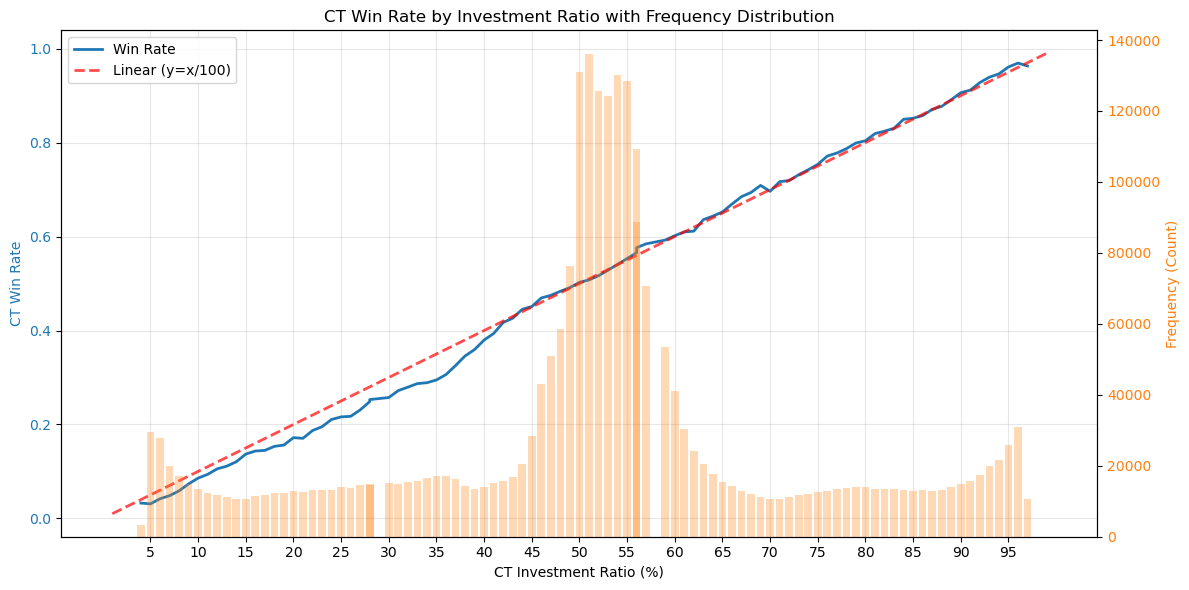

In [12]:


print(f"Outlier filtering for CT Investment Ratio (99% interval):")
print(f"  Original data: {len(detailed_df):,} rounds")
print(f"  Filtered data: {len(df_filtered_ratio):,} rounds")
print(f"  Removed: {len(detailed_df) - len(df_filtered_ratio):,} rounds ({(len(detailed_df) - len(df_filtered_ratio)) / len(detailed_df) * 100:.2f}%)")
print(f"  Range: {q_low_ratio:.4f} to {q_high_ratio:.4f}")
print()

win_rate_by_investment = df_filtered_ratio.groupby(pd.cut(df_filtered_ratio['ct_investment_ratio'], bins=np.arange(0, 1.0, 0.01)))['ct_winner'].agg(['mean', 'count'])



fig, ax1 = plt.subplots(figsize=(12, 6))

# Create integer labels from interval upper bounds (multiply by 100 for percentage)
x_labels = [int(interval.right * 100) for interval in win_rate_by_investment.index]

# Plot win rate on the first y-axis
color = 'tab:blue'
ax1.set_xlabel('CT Investment Ratio (%)')
ax1.set_ylabel('CT Win Rate', color=color)
ax1.plot(x_labels, win_rate_by_investment['mean'], color=color, linewidth=2, label='Win Rate')
# Add theoretical linear relationship y = x/100
ax1.plot(x_labels, [x/100 for x in x_labels], color='red', linewidth=2, linestyle='--', alpha=0.7, label='Linear (y=x/100)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Create second y-axis for frequency
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Frequency (Count)', color=color)
ax2.bar(x_labels, win_rate_by_investment['count'], alpha=0.3, color=color, label='Frequency', width=0.8)
ax2.tick_params(axis='y', labelcolor=color)

# Add title and set x-axis tick frequency
plt.title('CT Win Rate by Investment Ratio with Frequency Distribution')
ax1.set_xticks([x for x in x_labels if x % 5 == 0])  # Show every 5th label to avoid clutter
plt.tight_layout()
plt.show()

In [13]:
df_filtered_ratio['ct_t_log_ratio'] = np.log(df_filtered_ratio['ct_equipment'] / df_filtered_ratio['t_equipment'])


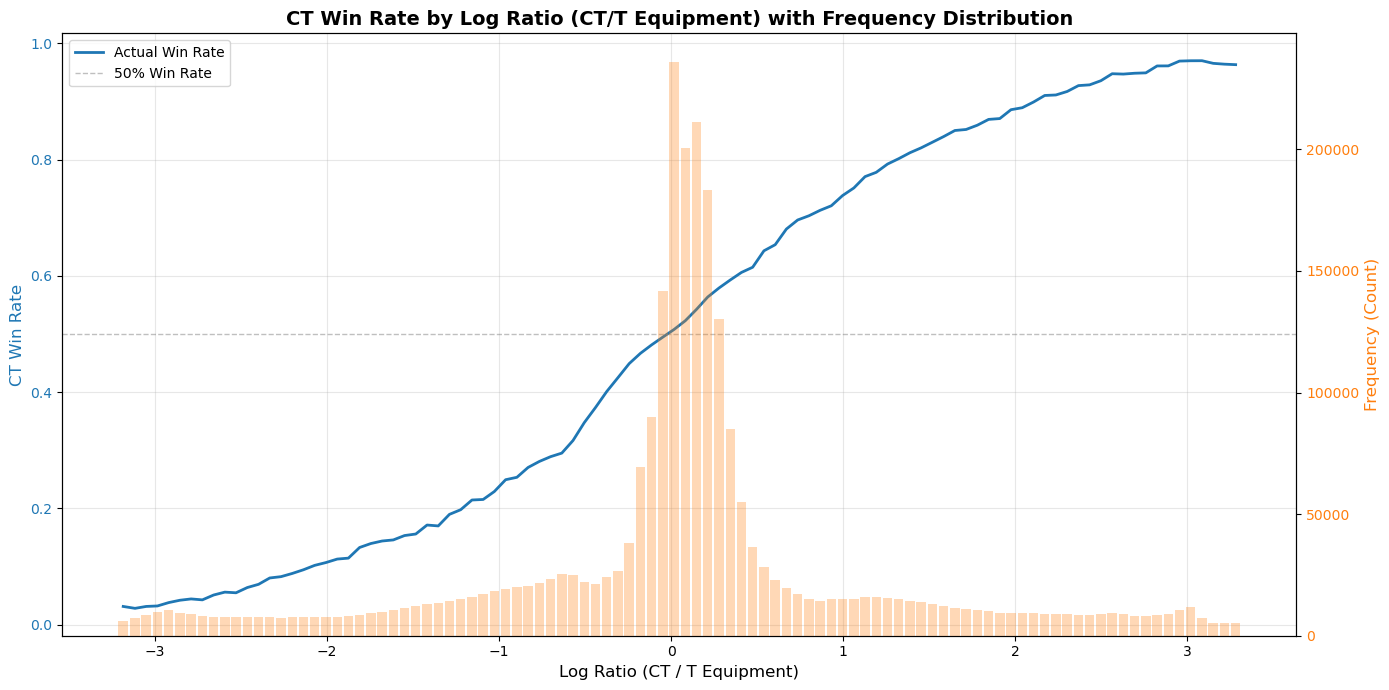

In [14]:




win_rate_by_investment_2 = df_filtered_ratio.groupby(pd.cut(df_filtered_ratio['ct_t_log_ratio'], bins=100))['ct_winner'].agg(['mean', 'count'])

fig, ax1 = plt.subplots(figsize=(14, 7))

# Extract midpoints of intervals for proper x-axis values
x_values = [interval.mid for interval in win_rate_by_investment_2.index]



# Plot win rate on the first y-axis
color = 'tab:blue'
ax1.set_xlabel('Log Ratio (CT / T Equipment)', fontsize=12)
ax1.set_ylabel('CT Win Rate', color=color, fontsize=12)
ax1.plot(x_values, win_rate_by_investment_2['mean'], color=color, linewidth=2, label='Actual Win Rate')
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='50% Win Rate')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Create second y-axis for frequency
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Frequency (Count)', color=color, fontsize=12)
ax2.bar(x_values, win_rate_by_investment_2['count'], alpha=0.3, color=color, label='Frequency', width=(x_values[1] - x_values[0]) * 0.8)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('CT Win Rate by Log Ratio (CT/T Equipment) with Frequency Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## Calculating the CSF parameter for r via the Logisitc Regression

Optimization terminated successfully.
         Current function value: 0.585990
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              ct_winner   No. Observations:              1801079
Model:                          Logit   Df Residuals:                  1801077
Method:                           MLE   Df Model:                            1
Date:                Fri, 13 Feb 2026   Pseudo R-squ.:                  0.1540
Time:                        11:44:27   Log-Likelihood:            -1.0554e+06
converged:                       True   LL-Null:                   -1.2475e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0025      0.002     -1.497      0.134      -0.006       0.001
ct_t_log_ratio   

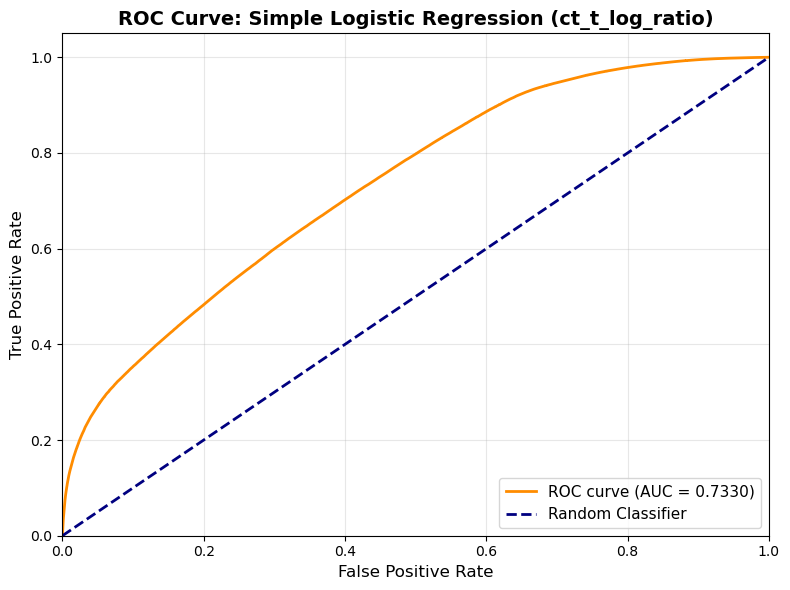

In [15]:


from sklearn.metrics import roc_auc_score


x_r = df_filtered_ratio[['ct_t_log_ratio']]
y = df_filtered_ratio['ct_winner']

# Split data
xtr_train, xtr_test, ytr_train, ytr_test = train_test_split(x_r, y, test_size=test_size_global, random_state=random_state_global)
# train dataset
log_model = sm.Logit(ytr_train, sm.add_constant(xtr_train))
result = log_model.fit()
print(result.summary())

# test dataset
yhat = result.predict(sm.add_constant(xtr_test))
prediction = list(map(round, yhat))

cm = confusion_matrix(ytr_test, prediction) 
auc_score = roc_auc_score(ytr_test, yhat)
fpr, tpr, _ = roc_curve(ytr_test, yhat)

# Additional goodness-of-fit measures
from sklearn.metrics import log_loss, brier_score_loss
brier_score = brier_score_loss(ytr_test, yhat)
logloss = log_loss(ytr_test, yhat)
precision, recall, f1, _ = precision_recall_fscore_support(ytr_test, prediction, average='binary')

print("="*80)
print("MODEL EVALUATION: SIMPLE LOGISTIC REGRESSION (ct_t_log_ratio)")
print("="*80)
print ("Confusion Matrix : \n", cm)
print()
print('Classification Metrics:')
print(f'  Test Accuracy  = {accuracy_score(ytr_test, prediction):.4f}')
print(f'  Precision      = {precision:.4f}')
print(f'  Recall         = {recall:.4f}')
print(f'  F1-Score       = {f1:.4f}')
print()
print('Probabilistic Metrics:')
print(f'  AUC-ROC        = {auc_score:.4f}')
print(f'  Brier Score    = {brier_score:.4f} (lower is better)')
print(f'  Log Loss       = {logloss:.4f} (lower is better)')
print()

# Plot ROC Curve
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='darkorange', linewidth=2, label=f'ROC curve (AUC = {auc_score:.4f})')
ax.plot([0, 1], [0, 1], color='navy', linewidth=2, linestyle='--', label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve: Simple Logistic Regression (ct_t_log_ratio)', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

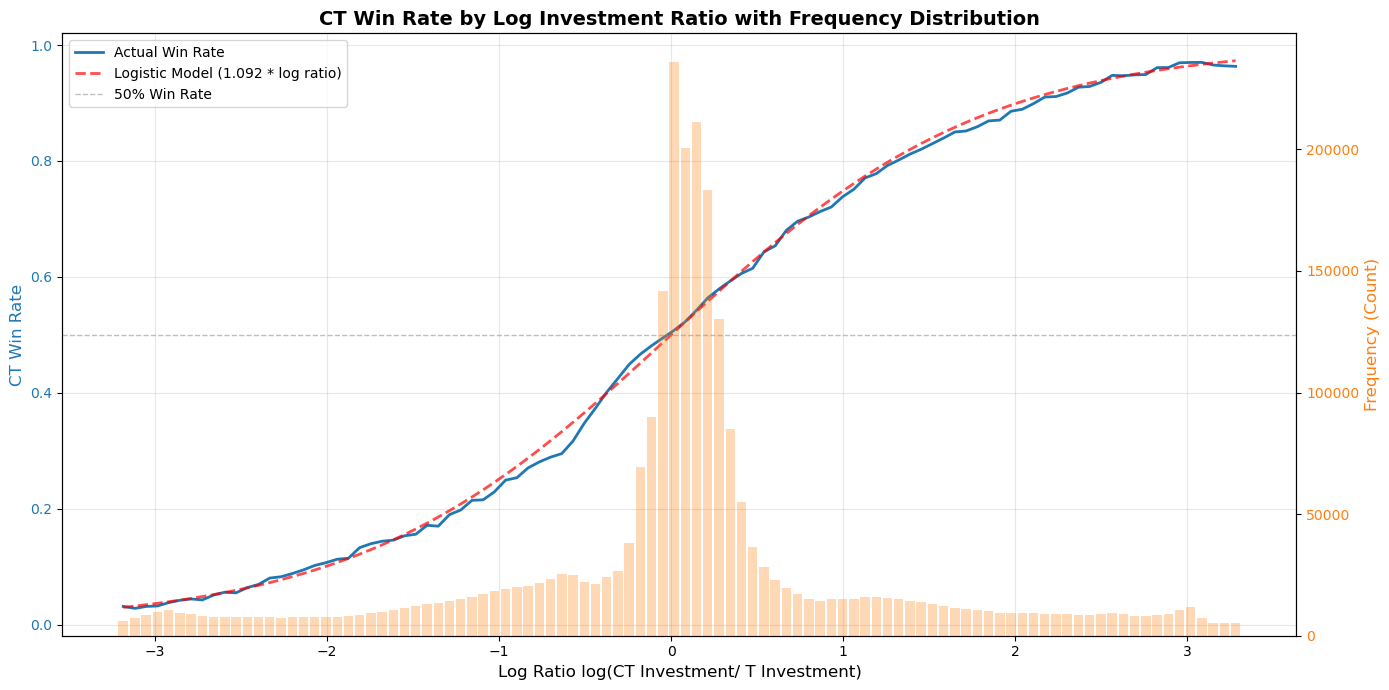

In [16]:

fig, ax1 = plt.subplots(figsize=(14, 7))

# Extract midpoints of intervals for proper x-axis values
x_values = [interval.mid for interval in win_rate_by_investment_2.index]

# Calculate theoretical linear relationship using the coefficient from logistic regression
from scipy.special import expit

# Get the coefficient for ct_t_log_ratio from the logistic regression result
log_ratio_coef = result.params['ct_t_log_ratio']
theoretical_win_rate = expit(log_ratio_coef * np.array(x_values))

# Plot win rate on the first y-axis
color = 'tab:blue'
ax1.set_xlabel('Log Ratio log(CT Investment/ T Investment)', fontsize=12)
ax1.set_ylabel('CT Win Rate', color=color, fontsize=12)
ax1.plot(x_values, win_rate_by_investment_2['mean'], color=color, linewidth=2, label='Actual Win Rate')
ax1.plot(x_values, theoretical_win_rate, color='red', linewidth=2, linestyle='--', alpha=0.7, label=f'Logistic Model ({log_ratio_coef:.3f} * log ratio)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='50% Win Rate')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Create second y-axis for frequency
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Frequency (Count)', color=color, fontsize=12)
ax2.bar(x_values, win_rate_by_investment_2['count'], alpha=0.3, color=color, label='Frequency', width=(x_values[1] - x_values[0]) * 0.8)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('CT Win Rate by Log Investment Ratio with Frequency Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### Asymmetric CSF model

# Maximum Likelihood Estimation for Contest Success Function (CSF)

We'll estimate the r parameter(s) that best fit our data using Maximum Likelihood Estimation (MLE).

The Contest Success Function models the probability that CT wins given the investment ratio:
- **CSF(x, r)** = ((CT_equipment^r / (CT_equipment ^r + T_Equipment ^r)) ^ CT_win) * ((T_equipment^r / (CT_equipment ^r + T_Equipment ^r)) ^ (1-CT_win)

Usually, the log-likelihood is used because it is easier to compute and more stable. I also check the the likelihood variation

In [17]:


# ============================================================================
# MLE FOR TULLOCK CONTEST SUCCESS FUNCTION (CSF)
# ============================================================================

def tullock_csf(ct_eq, t_eq, r):
    """
    Tullock Contest Success Function
    P(CT wins) = CT^r / (CT^r + T^r)
    """
    ct_r = np.power(ct_eq, r)
    t_r = np.power(t_eq, r)
    return ct_r / (ct_r + t_r)

def neg_log_likelihood_tullock(params, ct_equipment, t_equipment, ct_winner):
    """
    Negative log-likelihood for Tullock CSF
    
    Likelihood = ∏ [P(CT wins)]^(ct_win) * [P(T wins)]^(1-ct_win)
    Log-likelihood = Σ [ct_win * log(P(CT wins)) + (1-ct_win) * log(P(T wins))]
    
    Parameters:
    - params: [r] - the contest intensity parameter
    - ct_equipment: array of CT equipment values
    - t_equipment: array of T equipment values
    - ct_winner: array of binary outcomes (1 if CT won, 0 if T won)
    """
    r = params[0]
    
    # Ensure r is positive
    if r <= 0:
        return 1e10
    
    # Calculate P(CT wins) for each round
    p_ct = tullock_csf(ct_equipment, t_equipment, r)
    
    # Clip probabilities to avoid log(0)
    p_ct = np.clip(p_ct, 1e-10, 1 - 1e-10)
    p_t = 1 - p_ct
    
    # Log-likelihood: sum of [y*log(p_ct) + (1-y)*log(p_t)]
    log_lik = np.sum(ct_winner * np.log(p_ct) + (1 - ct_winner) * np.log(p_t))
    
    # Return negative log-likelihood (we minimize)
    return -log_lik

# ============================================================================
# PREPARE DATA
# ============================================================================
print("="*80)
print("MAXIMUM LIKELIHOOD ESTIMATION FOR TULLOCK CSF")
print("="*80)
print()

# Extract equipment values and outcomes
ct_eq = df_filtered_ratio['ct_equipment'].values
t_eq = df_filtered_ratio['t_equipment'].values
ct_win = df_filtered_ratio['ct_winner'].values

print(f"📊 Data prepared:")
print(f"   Total rounds: {len(ct_eq):,}")
print(f"   CT wins: {ct_win.sum():,} ({ct_win.mean()*100:.2f}%)")
print(f"   T wins: {(1-ct_win).sum():,} ({(1-ct_win).mean()*100:.2f}%)")
print()

# ============================================================================
# OPTIMIZE TO FIND OPTIMAL r
# ============================================================================
print("Running Maximum Likelihood Estimation...")
print("-" * 80)

# Initial guess for r
r0 = [1.0]

# Run optimization
result_mle = minimize(
    neg_log_likelihood_tullock,
    r0,
    args=(ct_eq, t_eq, ct_win),
    method='Nelder-Mead',
    options={'maxiter': 10000, 'disp': True}
)

# Extract results
r_optimal = result_mle.x[0]
neg_ll = result_mle.fun
log_likelihood = -neg_ll


print()
print("="*80)
print("MLE RESULTS - TULLOCK CSF")
print("="*80)

print(f"Optimal r parameter: {r_optimal:.6f}")
print(f"Log-Likelihood: {log_likelihood:.2f}")
print(f"Negative Log-Likelihood: {neg_ll:.2f}")
print(f"Optimization converged: {result_mle.success}")
print(f"Iterations: {result_mle.nit}")
print()

# ============================================================================
# WALD TEST FOR PARAMETER r
# ============================================================================
print("="*80)
print("WALD TEST FOR PARAMETER r")
print("="*80)
print()

# Calculate Hessian matrix (second derivatives) at optimal r
# Use numerical differentiation to estimate standard error
from scipy.optimize import approx_fprime

def compute_hessian(params, ct_equipment, t_equipment, ct_winner, eps=1e-5):
    """
    Compute Hessian (second derivative matrix) numerically
    For 1D parameter, this is just the second derivative
    """
    r = params[0]
    
    # Compute gradient at r + eps and r - eps
    grad_plus = approx_fprime([r + eps], neg_log_likelihood_tullock, eps, ct_equipment, t_equipment, ct_winner)
    grad_minus = approx_fprime([r - eps], neg_log_likelihood_tullock, eps, ct_equipment, t_equipment, ct_winner)
    
    # Numerical second derivative
    hessian = (grad_plus - grad_minus) / (2 * eps)
    
    return hessian[0]

print("📊 Computing standard error via Hessian matrix...")
hessian = compute_hessian([r_optimal], ct_eq, t_eq, ct_win)

# Standard error is sqrt of inverse of negative Hessian
# For MLE, Var(θ) ≈ [-H(θ)]^(-1) where H is Hessian of log-likelihood
se_r = np.sqrt(1 / hessian) if hessian > 0 else np.nan

print(f"   Hessian at optimal r: {hessian:.4f}")
print(f"   Standard Error of r: {se_r:.6f}")
print()

# ============================================================================
# CONFIDENCE INTERVALS
# ============================================================================
print("📊 95% Confidence Interval for r:")
print("-" * 80)

# 95% CI: estimate ± 1.96 * SE
z_critical = 1.96  # 95% confidence level
ci_lower = r_optimal - z_critical * se_r
ci_upper = r_optimal + z_critical * se_r

print(f"   Point Estimate: r = {r_optimal:.6f}")
print(f"   95% CI: [{ci_lower:.6f}, {ci_upper:.6f}]")
print()

# ============================================================================
# HYPOTHESIS TESTS
# ============================================================================
print("📊 Wald Tests for Key Hypotheses:")
print("-" * 80)
print()

# Test 1: H0: r = 1 (Linear relationship)
r_null_1 = 1.0
wald_stat_1 = (r_optimal - r_null_1) / se_r
p_value_1 = 2 * (1 - stats.norm.cdf(abs(wald_stat_1)))  # Two-tailed test

print(f"Test 1: H₀: r = 1 (Linear Contest)")
print(f"   H₀: Investment has proportional effect")
print(f"   H₁: Investment effect is non-linear")
print(f"   Wald statistic: {wald_stat_1:.4f}")
print(f"   P-value: {p_value_1:.6f}")
if p_value_1 < 0.05:
    print(f"   ✅ Reject H₀ at α=0.05: r is significantly different from 1")
    if r_optimal > 1:
        print(f"      → Equipment differences are AMPLIFIED (winner-favoring)")
    else:
        print(f"      → Equipment differences are DAMPENED (underdog-favoring)")
else:
    print(f"   ❌ Fail to reject H₀: r ≈ 1 (approximately linear)")
print()

# Test 2: H0: r = 0.5 (Weakly decisive)
r_null_2 = 0.5
wald_stat_2 = (r_optimal - r_null_2) / se_r
p_value_2 = 2 * (1 - stats.norm.cdf(abs(wald_stat_2)))

print(f"Test 2: H₀: r = 0.5 (Weakly Decisive Contest)")
print(f"   H₀: Investment has weak effect")
print(f"   H₁: Investment effect is stronger")
print(f"   Wald statistic: {wald_stat_2:.4f}")
print(f"   P-value: {p_value_2:.6f}")
if p_value_2 < 0.05:
    print(f"   ✅ Reject H₀ at α=0.05: r is significantly different from 0.5")
else:
    print(f"   ❌ Fail to reject H₀: r ≈ 0.5")
print()

# Test 3: H0: r = 2 (Strongly decisive)
r_null_3 = 2.0
wald_stat_3 = (r_optimal - r_null_3) / se_r
p_value_3 = 2 * (1 - stats.norm.cdf(abs(wald_stat_3)))

print(f"Test 3: H₀: r = 2 (Strongly Decisive Contest)")
print(f"   H₀: Investment has very strong effect")
print(f"   H₁: Investment effect is different")
print(f"   Wald statistic: {wald_stat_3:.4f}")
print(f"   P-value: {p_value_3:.6f}")
if p_value_3 < 0.05:
    print(f"   ✅ Reject H₀ at α=0.05: r is significantly different from 2")
else:
    print(f"   ❌ Fail to reject H₀: r ≈ 2")
print()

# ============================================================================
# Z-SCORE AND SIGNIFICANCE
# ============================================================================
print("📊 Statistical Significance:")
print("-" * 80)
z_score = r_optimal / se_r  # Test if r is significantly different from 0
p_value_zero = 2 * (1 - stats.norm.cdf(abs(z_score)))

print(f"   Z-score (r ≠ 0): {z_score:.4f}")
print(f"   P-value: {p_value_zero:.10f}")
print(f"   Significance: {'***' if p_value_zero < 0.001 else '**' if p_value_zero < 0.01 else '*' if p_value_zero < 0.05 else 'n.s.'}")
print()



MAXIMUM LIKELIHOOD ESTIMATION FOR TULLOCK CSF

📊 Data prepared:
   Total rounds: 2,572,971
   CT wins: 1,326,611 (51.56%)
   T wins: 1,246,360 (48.44%)

Running Maximum Likelihood Estimation...
--------------------------------------------------------------------------------
Optimization terminated successfully.
         Current function value: 1508185.025616
         Iterations: 12
         Function evaluations: 24

MLE RESULTS - TULLOCK CSF
Optimal r parameter: 1.090723
Log-Likelihood: -1508185.03
Negative Log-Likelihood: 1508185.03
Optimization converged: True
Iterations: 12

WALD TEST FOR PARAMETER r

📊 Computing standard error via Hessian matrix...
   Hessian at optimal r: 272324.5416
   Standard Error of r: 0.001916

📊 95% Confidence Interval for r:
--------------------------------------------------------------------------------
   Point Estimate: r = 1.090723
   95% CI: [1.086967, 1.094479]

📊 Wald Tests for Key Hypotheses:
--------------------------------------------------------

### summary of the logistic regression and log-likelihood MLE 

In [18]:
# ============================================================================
# COMPARISON TABLE: LOGISTIC REGRESSION vs MLE ESTIMATION
# ============================================================================

print("="*80)
print("COMPARISON: LOGISTIC REGRESSION vs MAXIMUM LIKELIHOOD ESTIMATION")
print("="*80)
print()

# Create comparison dataframe
comparison_data = {
    'Method': ['Logistic Regression', 'MLE (Tullock CSF)'],
    'Parameter': ['β (coefficient)', 'r (intensity)'],
    'Estimate': [
        result.params['ct_t_log_ratio'],
        r_optimal
    ],
    'Std. Error': [
        result.bse['ct_t_log_ratio'],
        se_r
    ],
    '95% CI Lower': [
        result.conf_int().loc['ct_t_log_ratio', 0],
        ci_lower
    ],
    '95% CI Upper': [
        result.conf_int().loc['ct_t_log_ratio', 1],
        ci_upper
    ],
    'Log-Likelihood': [
        result.llf,
        log_likelihood
    ],
    'AIC': [
        result.aic,
        2 * 2 - 2 * log_likelihood  # AIC = 2k - 2*log(L), k=2 (intercept + r)
    ],
    'BIC': [
        result.bic,
        np.log(len(ct_eq)) * 2 - 2 * log_likelihood  # BIC = k*log(n) - 2*log(L)
    ],
    'N': [
        result.nobs,
        len(ct_eq)
    ]
}

comparison_df = pd.DataFrame(comparison_data)

# Display with nice formatting
print(comparison_df.to_string(index=False))
print()
print("="*80)

# Create a publication-ready CSV table
print("\nCSV Table for Thesis for Table:")
print("="*80)
csv_table = comparison_df.to_csv(index=False, sep=';')
print(csv_table)
print("="*80)

# Create a more detailed comparison focusing on key metrics
print("\nDetailed Statistical Comparison:")
print("="*80)
print()

# Calculate p-values for significance indicators
p_value_lr_zero = result.pvalues['ct_t_log_ratio']
p_value_lr_one = 2 * (1 - stats.norm.cdf(abs((result.params['ct_t_log_ratio'] - 1) / result.bse['ct_t_log_ratio'])))

detailed_comparison = pd.DataFrame({
    'Metric': [
        'Parameter Estimate',
        'Standard Error',
        '95% Confidence Interval',
        'Z-statistic (H₀: param = 0)',
        'P-value (param ≠ 0)',
        'Test: H₀: param = 1',
        'P-value (param = 1)',
        'Log-Likelihood',
        'AIC',
        'BIC',
        'Sample Size'
    ],
    'Logistic Regression': [
        f"{result.params['ct_t_log_ratio']:.4f}",
        f"{result.bse['ct_t_log_ratio']:.4f}",
        f"[{result.conf_int().loc['ct_t_log_ratio', 0]:.4f}, {result.conf_int().loc['ct_t_log_ratio', 1]:.4f}]",
        f"{result.tvalues['ct_t_log_ratio']:.4f}",
        f"{p_value_lr_zero:.6f}",
        f"{(result.params['ct_t_log_ratio'] - 1) / result.bse['ct_t_log_ratio']:.4f}",
        f"{p_value_lr_one:.6f}",
        f"{result.llf:.2f}",
        f"{result.aic:.2f}",
        f"{result.bic:.2f}",
        f"{int(result.nobs):,}"
    ],
    'MLE (Tullock CSF)': [
        f"{r_optimal:.4f}",
        f"{se_r:.4f}",
        f"[{ci_lower:.4f}, {ci_upper:.4f}]",
        f"{z_score:.4f}",
        f"{p_value_zero:.6f}",
        f"{wald_stat_1:.4f}",
        f"{p_value_1:.6f}",
        f"{log_likelihood:.2f}",
        f"{2 * 2 - 2 * log_likelihood:.2f}",
        f"{np.log(len(ct_eq)) * 2 - 2 * log_likelihood:.2f}",
        f"{len(ct_eq):,}"
    ],
    'Sig. (p<0.005)': [
        '***' if p_value_lr_zero < 0.005 else ('**' if p_value_lr_zero < 0.01 else ('*' if p_value_lr_zero < 0.05 else '')),
        '',
        '',
        '',
        '***' if p_value_lr_zero < 0.005 else ('**' if p_value_lr_zero < 0.01 else ('*' if p_value_lr_zero < 0.05 else '')),
        '',
        '***' if p_value_lr_one < 0.005 else ('**' if p_value_lr_one < 0.01 else ('*' if p_value_lr_one < 0.05 else '')),
        '',
        '',
        '',
        ''
    ],
    'MLE Sig. (p<0.005)': [
        '***' if p_value_zero < 0.005 else ('**' if p_value_zero < 0.01 else ('*' if p_value_zero < 0.05 else '')),
        '',
        '',
        '',
        '***' if p_value_zero < 0.005 else ('**' if p_value_zero < 0.01 else ('*' if p_value_zero < 0.05 else '')),
        '',
        '***' if p_value_1 < 0.005 else ('**' if p_value_1 < 0.01 else ('*' if p_value_1 < 0.05 else '')),
        '',
        '',
        '',
        ''
    ]
})

print(detailed_comparison.to_string(index=False))
print()
print("Note: Significance levels: *** p<0.005, ** p<0.01, * p<0.05")
print()
print("="*80)

# Create publication-ready table for detailed comparison
print("\nCSV Table (Detailed) for Thesis for Table:")
print("="*80)
csv_detailed = detailed_comparison.to_csv(index=False,  sep=';')
print(csv_detailed)
print()
print("Note: Significance levels indicated by asterisks")
print("  *** = p < 0.005 (highly significant)")
print("  **  = p < 0.01  (very significant)")
print("  *   = p < 0.05  (significant)")
print("="*80)



COMPARISON: LOGISTIC REGRESSION vs MAXIMUM LIKELIHOOD ESTIMATION

             Method       Parameter  Estimate  Std. Error  95% CI Lower  95% CI Upper  Log-Likelihood          AIC          BIC       N
Logistic Regression β (coefficient)  1.091901    0.002300      1.087394      1.096408   -1.055415e+06 2.110834e+06 2.110858e+06 1801079
  MLE (Tullock CSF)   r (intensity)  1.090723    0.001916      1.086967      1.094479   -1.508185e+06 3.016374e+06 3.016400e+06 2572971


CSV Table for Thesis for Table:
Method;Parameter;Estimate;Std. Error;95% CI Lower;95% CI Upper;Log-Likelihood;AIC;BIC;N
Logistic Regression;β (coefficient);1.0919009020667825;0.0022996522435068437;1.0873936664925423;1.0964081376410226;-1055414.7762126995;2110833.552425399;2110858.3602183745;1801079
MLE (Tullock CSF);r (intensity);1.09072265625;0.0019162695975474522;1.086966767838807;1.094478544661193;-1508185.0256161366;3016374.051232273;3016399.5723759136;2572971


Detailed Statistical Comparison:

                   

# Asymmetric model estimated with logistic regression

Optimization terminated successfully.
         Current function value: 0.585985
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              ct_winner   No. Observations:              1801079
Model:                          Logit   Df Residuals:                  1801076
Method:                           MLE   Df Model:                            2
Date:                Fri, 13 Feb 2026   Pseudo R-squ.:                  0.1540
Time:                        11:44:38   Log-Likelihood:            -1.0554e+06
converged:                       True   LL-Null:                   -1.2475e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1237      0.028     -4.450      0.000      -0.178      -0.069
ct_equipmen

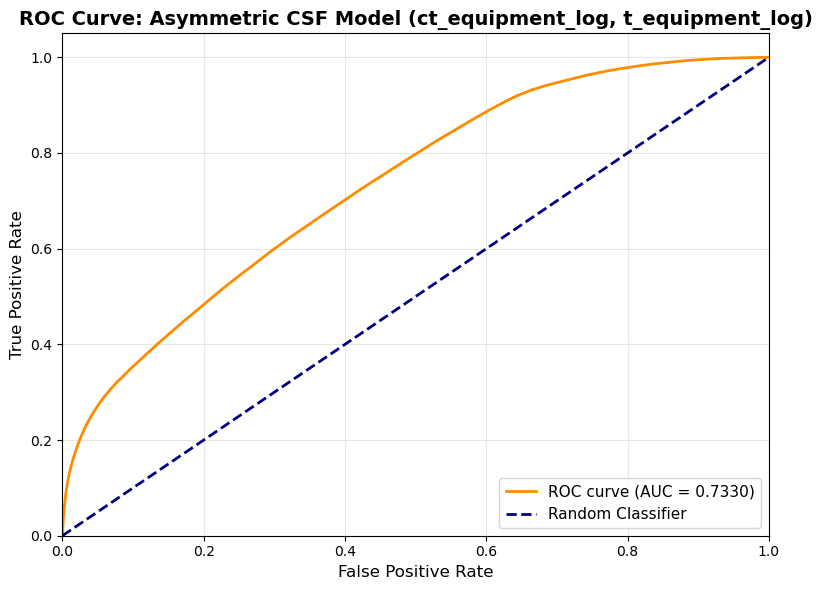

In [19]:
df_filtered_ratio['ct_equipment_log'] = np.log(df_filtered_ratio['ct_equipment'])
df_filtered_ratio['t_equipment_log'] = np.log(df_filtered_ratio['t_equipment'])

x_r = df_filtered_ratio[['ct_equipment_log', 't_equipment_log']]
y = df_filtered_ratio['ct_winner']

# Split data
xtr_train, xtr_test, ytr_train, ytr_test = train_test_split(x_r, y, test_size=test_size_global, random_state=random_state_global)
# train dataset
log_model = sm.Logit(ytr_train, sm.add_constant(xtr_train))
result_2 = log_model.fit()
print(result_2.summary())

# test dataset
yhat = result_2.predict(sm.add_constant(xtr_test))
prediction = list(map(round, yhat))

cm = confusion_matrix(ytr_test, prediction) 
auc_score = roc_auc_score(ytr_test, yhat)
fpr, tpr, _ = roc_curve(ytr_test, yhat)

# Additional goodness-of-fit measures
from sklearn.metrics import log_loss, brier_score_loss
brier_score = brier_score_loss(ytr_test, yhat)
logloss = log_loss(ytr_test, yhat)
precision, recall, f1, _ = precision_recall_fscore_support(ytr_test, prediction, average='binary')

print("="*80)
print("MODEL EVALUATION: ASYMMETRIC CSF MODEL (ct_equipment_log, t_equipment_log)")
print("="*80)
print ("Confusion Matrix : \n", cm)
print()
print('Classification Metrics:')
print(f'  Test Accuracy  = {accuracy_score(ytr_test, prediction):.4f}')
print(f'  Precision      = {precision:.4f}')
print(f'  Recall         = {recall:.4f}')
print(f'  F1-Score       = {f1:.4f}')
print()
print('Probabilistic Metrics:')
print(f'  AUC-ROC        = {auc_score:.4f}')
print(f'  Brier Score    = {brier_score:.4f} (lower is better)')
print(f'  Log Loss       = {logloss:.4f} (lower is better)')
print()

# Plot ROC Curve
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='darkorange', linewidth=2, label=f'ROC curve (AUC = {auc_score:.4f})')
ax.plot([0, 1], [0, 1], color='navy', linewidth=2, linestyle='--', label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve: Asymmetric CSF Model (ct_equipment_log, t_equipment_log)', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show() 

## Asymmetric Tullock CSF - Maximum Likelihood Estimation

Estimating an asymmetric Contest Success Function where CT and T teams have different effectiveness parameters (r_ct and r_t):

$$P(CT\_wins) = \frac{x_{CT}^{r_{CT}}}{x_{CT}^{r_{CT}} + x_T^{r_T}}$$

This allows for asymmetric returns to investment between the two teams.

ASYMMETRIC TULLOCK CSF - MAXIMUM LIKELIHOOD ESTIMATION

Optimizing asymmetric Tullock CSF parameters...
Initial guess: r_ct = 1.0907, r_t = 1.0907

Optimization Results:
  r_ct (CT effectiveness) = 1.090707
  r_t (T effectiveness)   = 1.090939
  Log-Likelihood          = -1508183.67
  Optimization success: True

Standard Errors:
  SE(r_ct) = 0.001920
  SE(r_t)  = 0.001932

95% Confidence Intervals:
  r_ct: [1.086945, 1.094470]
  r_t:  [1.087152, 1.094726]

Hypothesis Tests:
--------------------------------------------------------------------------------
H₀: r_ct = 1
  Wald statistic: 47.2503
  P-value: 0.000000
  Result: Reject H₀ - CT effectiveness differs from linear (r=1)

H₀: r_t = 1
  Wald statistic: 47.0673
  P-value: 0.000000
  Result: Reject H₀ - T effectiveness differs from linear (r=1)

H₀: r_ct = r_t (Symmetric CSF)
  Difference: r_ct - r_t = -0.000232
  Wald statistic: -1.6453
  P-value: 0.099903
  Result: Fail to reject H₀ - Symmetric model is adequate

Model Fit Statistic

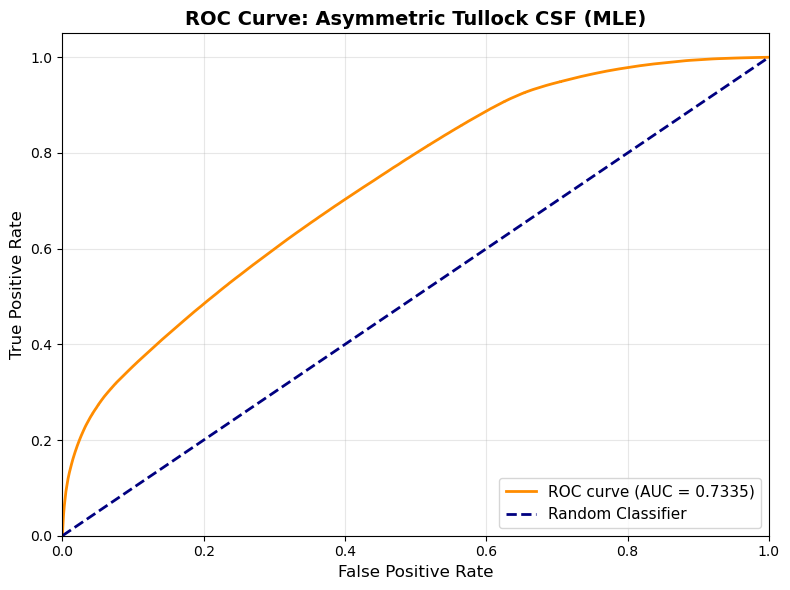

In [20]:
# ============================================================================
# ASYMMETRIC TULLOCK CSF - MAXIMUM LIKELIHOOD ESTIMATION
# ============================================================================

# Define the asymmetric Tullock CSF log-likelihood function
def asymmetric_tullock_log_likelihood(params, x_ct, x_t, y):
    """
    Negative log-likelihood for asymmetric Tullock CSF.
    
    Parameters:
    - params: [r_ct, r_t] - effectiveness parameters for CT and T teams
    - x_ct: CT equipment values
    - x_t: T equipment values
    - y: binary outcomes (1 if CT wins, 0 if T wins)
    
    Returns:
    - Negative log-likelihood (for minimization)
    """
    r_ct, r_t = params
    
    # Prevent invalid parameter values
    if r_ct <= 0 or r_t <= 0:
        return np.inf
    
    # Calculate win probabilities using asymmetric Tullock CSF
    ct_power = np.power(x_ct, r_ct)
    t_power = np.power(x_t, r_t)
    p_ct_wins = ct_power / (ct_power + t_power)
    
    # Clip probabilities to avoid log(0)
    p_ct_wins = np.clip(p_ct_wins, 1e-10, 1 - 1e-10)
    
    # Calculate log-likelihood
    log_likelihood = np.sum(y * np.log(p_ct_wins) + (1 - y) * np.log(1 - p_ct_wins))
    
    return -log_likelihood  # Return negative for minimization

# Initial guess: start from symmetric solution
initial_params = [r_optimal, r_optimal]

# Optimize to find r_ct and r_t
print("="*80)
print("ASYMMETRIC TULLOCK CSF - MAXIMUM LIKELIHOOD ESTIMATION")
print("="*80)
print()
print("Optimizing asymmetric Tullock CSF parameters...")
print(f"Initial guess: r_ct = {initial_params[0]:.4f}, r_t = {initial_params[1]:.4f}")
print()

result_mle_asym = minimize(
    asymmetric_tullock_log_likelihood,
    initial_params,
    args=(ct_eq, t_eq, ct_win),
    method='L-BFGS-B',
    bounds=[(0.01, 5.0), (0.01, 5.0)]  # Reasonable bounds for r parameters
)

r_ct_optimal = result_mle_asym.x[0]
r_t_optimal = result_mle_asym.x[1]
log_likelihood_asym = -result_mle_asym.fun

print("Optimization Results:")
print(f"  r_ct (CT effectiveness) = {r_ct_optimal:.6f}")
print(f"  r_t (T effectiveness)   = {r_t_optimal:.6f}")
print(f"  Log-Likelihood          = {log_likelihood_asym:.2f}")
print(f"  Optimization success: {result_mle_asym.success}")
print()

# Calculate standard errors using Hessian
from scipy.optimize import approx_fprime

def neg_ll_asym(params):
    return asymmetric_tullock_log_likelihood(params, ct_eq, t_eq, ct_win)

# Compute Hessian numerically
epsilon = 1e-5
hessian_asym = np.zeros((2, 2))
for i in range(2):
    for j in range(2):
        params_plus_i = result_mle_asym.x.copy()
        params_plus_j = result_mle_asym.x.copy()
        params_plus_ij = result_mle_asym.x.copy()
        
        params_plus_i[i] += epsilon
        params_plus_j[j] += epsilon
        params_plus_ij[i] += epsilon
        params_plus_ij[j] += epsilon
        
        hessian_asym[i, j] = (
            neg_ll_asym(params_plus_ij) 
            - neg_ll_asym(params_plus_i) 
            - neg_ll_asym(params_plus_j) 
            + neg_ll_asym(result_mle_asym.x)
        ) / (epsilon ** 2)

# Covariance matrix is inverse of Hessian
try:
    cov_matrix_asym = np.linalg.inv(hessian_asym)
    se_r_ct = np.sqrt(cov_matrix_asym[0, 0])
    se_r_t = np.sqrt(cov_matrix_asym[1, 1])
    
    print("Standard Errors:")
    print(f"  SE(r_ct) = {se_r_ct:.6f}")
    print(f"  SE(r_t)  = {se_r_t:.6f}")
    print()
    
    # Confidence intervals
    z_critical = 1.96  # 95% CI
    ci_lower_ct = r_ct_optimal - z_critical * se_r_ct
    ci_upper_ct = r_ct_optimal + z_critical * se_r_ct
    ci_lower_t = r_t_optimal - z_critical * se_r_t
    ci_upper_t = r_t_optimal + z_critical * se_r_t
    
    print("95% Confidence Intervals:")
    print(f"  r_ct: [{ci_lower_ct:.6f}, {ci_upper_ct:.6f}]")
    print(f"  r_t:  [{ci_lower_t:.6f}, {ci_upper_t:.6f}]")
    print()
    
except np.linalg.LinAlgError:
    print("Warning: Could not compute standard errors (singular Hessian matrix)")
    se_r_ct = np.nan
    se_r_t = np.nan
    ci_lower_ct = np.nan
    ci_upper_ct = np.nan
    ci_lower_t = np.nan
    ci_upper_t = np.nan

# Hypothesis tests
print("Hypothesis Tests:")
print("-" * 80)

# Test H0: r_ct = 1
if not np.isnan(se_r_ct):
    wald_stat_ct_1 = (r_ct_optimal - 1) / se_r_ct
    p_value_ct_1 = 2 * (1 - stats.norm.cdf(abs(wald_stat_ct_1)))
    print(f"H₀: r_ct = 1")
    print(f"  Wald statistic: {wald_stat_ct_1:.4f}")
    print(f"  P-value: {p_value_ct_1:.6f}")
    if p_value_ct_1 < 0.05:
        print("  Result: Reject H₀ - CT effectiveness differs from linear (r=1)")
    else:
        print("  Result: Fail to reject H₀ - CT effectiveness consistent with linear")
    print()

# Test H0: r_t = 1
if not np.isnan(se_r_t):
    wald_stat_t_1 = (r_t_optimal - 1) / se_r_t
    p_value_t_1 = 2 * (1 - stats.norm.cdf(abs(wald_stat_t_1)))
    print(f"H₀: r_t = 1")
    print(f"  Wald statistic: {wald_stat_t_1:.4f}")
    print(f"  P-value: {p_value_t_1:.6f}")
    if p_value_t_1 < 0.05:
        print("  Result: Reject H₀ - T effectiveness differs from linear (r=1)")
    else:
        print("  Result: Fail to reject H₀ - T effectiveness consistent with linear")
    print()

# Test H0: r_ct = r_t (symmetry test)
if not np.isnan(se_r_ct) and not np.isnan(se_r_t):
    # Variance of difference: Var(r_ct - r_t) = Var(r_ct) + Var(r_t) - 2*Cov(r_ct, r_t)
    var_diff = cov_matrix_asym[0, 0] + cov_matrix_asym[1, 1] - 2 * cov_matrix_asym[0, 1]
    se_diff = np.sqrt(var_diff)
    wald_stat_symmetry = (r_ct_optimal - r_t_optimal) / se_diff
    p_value_symmetry = 2 * (1 - stats.norm.cdf(abs(wald_stat_symmetry)))
    print(f"H₀: r_ct = r_t (Symmetric CSF)")
    print(f"  Difference: r_ct - r_t = {r_ct_optimal - r_t_optimal:.6f}")
    print(f"  Wald statistic: {wald_stat_symmetry:.4f}")
    print(f"  P-value: {p_value_symmetry:.6f}")
    if p_value_symmetry < 0.05:
        print("  Result: Reject H₀ - Asymmetric model is justified")
    else:
        print("  Result: Fail to reject H₀ - Symmetric model is adequate")
    print()

# Model fit statistics
n_params_asym = 2
aic_asym = 2 * n_params_asym - 2 * log_likelihood_asym
bic_asym = np.log(len(ct_eq)) * n_params_asym - 2 * log_likelihood_asym

print("Model Fit Statistics:")
print(f"  Log-Likelihood: {log_likelihood_asym:.2f}")
print(f"  AIC: {aic_asym:.2f}")
print(f"  BIC: {bic_asym:.2f}")
print(f"  N: {len(ct_eq):,}")
print()
print("="*80)

# Calculate predictions for visualization
p_ct_wins_asym = (np.power(ct_eq, r_ct_optimal)) / (np.power(ct_eq, r_ct_optimal) + np.power(t_eq, r_t_optimal))

# Calculate ROC metrics for asymmetric MLE model
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr_asym, tpr_asym, _ = roc_curve(ct_win, p_ct_wins_asym)
auc_score_asym = roc_auc_score(ct_win, p_ct_wins_asym)
brier_score_asym = brier_score_loss(ct_win, p_ct_wins_asym)
logloss_asym = log_loss(ct_win, p_ct_wins_asym)

# Classification metrics
prediction_asym = list(map(round, p_ct_wins_asym))
cm_asym = confusion_matrix(ct_win, prediction_asym)
precision_asym, recall_asym, f1_asym, _ = precision_recall_fscore_support(ct_win, prediction_asym, average='binary')

print()
print("MODEL EVALUATION: ASYMMETRIC TULLOCK CSF (MLE)")
print("="*80)
print("Confusion Matrix:")
print(cm_asym)
print()
print('Classification Metrics:')
print(f'  Test Accuracy  = {accuracy_score(ct_win, prediction_asym):.4f}')
print(f'  Precision      = {precision_asym:.4f}')
print(f'  Recall         = {recall_asym:.4f}')
print(f'  F1-Score       = {f1_asym:.4f}')
print()
print('Probabilistic Metrics:')
print(f'  AUC-ROC        = {auc_score_asym:.4f}')
print(f'  Brier Score    = {brier_score_asym:.4f} (lower is better)')
print(f'  Log Loss       = {logloss_asym:.4f} (lower is better)')
print()

# Plot ROC Curve
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr_asym, tpr_asym, color='darkorange', linewidth=2, label=f'ROC curve (AUC = {auc_score_asym:.4f})')
ax.plot([0, 1], [0, 1], color='navy', linewidth=2, linestyle='--', label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve: Asymmetric Tullock CSF (MLE)', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Likelihood Ratio Test: Symmetric vs Asymmetric Models

Compare the nested models using likelihood ratio tests to determine if the added complexity of asymmetric parameters is statistically justified.

In [21]:
# ============================================================================
# LIKELIHOOD RATIO TEST: SYMMETRIC vs ASYMMETRIC MODELS
# ============================================================================

print("="*80)
print("LIKELIHOOD RATIO TEST: SYMMETRIC vs ASYMMETRIC MODELS")
print("="*80)
print()

# ============================================================================
# 1. MLE Models Comparison (Tullock CSF)
# ============================================================================
print("1. TULLOCK CSF: Symmetric vs Asymmetric (MLE)")
print("-" * 80)

# Symmetric model: 1 parameter (r)
# Asymmetric model: 2 parameters (r_ct, r_t)

ll_symmetric_mle = log_likelihood
ll_asymmetric_mle = log_likelihood_asym
df_mle = 1  # Difference in number of parameters (2 - 1)

# Likelihood ratio test statistic
lr_stat_mle = 2 * (ll_asymmetric_mle - ll_symmetric_mle)
p_value_lr_mle = 1 - stats.chi2.cdf(lr_stat_mle, df_mle)

print(f"Symmetric Model (1 param):")
print(f"  r = {r_optimal:.6f}")
print(f"  Log-Likelihood = {ll_symmetric_mle:.2f}")
print(f"  AIC = {2 * 1 - 2 * ll_symmetric_mle:.2f}")
print(f"  BIC = {np.log(len(ct_eq)) * 1 - 2 * ll_symmetric_mle:.2f}")
print()

print(f"Asymmetric Model (2 params):")
print(f"  r_ct = {r_ct_optimal:.6f}")
print(f"  r_t  = {r_t_optimal:.6f}")
print(f"  Log-Likelihood = {ll_asymmetric_mle:.2f}")
print(f"  AIC = {aic_asym:.2f}")
print(f"  BIC = {bic_asym:.2f}")
print()

print(f"Likelihood Ratio Test:")
print(f"  LR Statistic = {lr_stat_mle:.4f}")
print(f"  Degrees of Freedom = {df_mle}")
print(f"  P-value = {p_value_lr_mle:.6f}")
print()

if p_value_lr_mle < 0.05:
    print(f"  ✓ Result: Asymmetric model provides significantly better fit (p < 0.05)")
else:
    print(f"  ✗ Result: Symmetric model is adequate (p ≥ 0.05)")

# AIC and BIC comparison
aic_symmetric_mle = 2 * 1 - 2 * ll_symmetric_mle
bic_symmetric_mle = np.log(len(ct_eq)) * 1 - 2 * ll_symmetric_mle
delta_aic_mle = aic_asym - aic_symmetric_mle
delta_bic_mle = bic_asym - bic_symmetric_mle

print()
print(f"Information Criteria Comparison:")
print(f"  ΔAIC = {delta_aic_mle:.2f} (negative favors asymmetric)")
print(f"  ΔBIC = {delta_bic_mle:.2f} (negative favors asymmetric)")

if delta_aic_mle < -10:
    print("  AIC: Strong evidence for asymmetric model")
elif delta_aic_mle < -4:
    print("  AIC: Moderate evidence for asymmetric model")
elif delta_aic_mle < 0:
    print("  AIC: Weak evidence for asymmetric model")
else:
    print("  AIC: No evidence for asymmetric model")

if delta_bic_mle < -10:
    print("  BIC: Strong evidence for asymmetric model")
elif delta_bic_mle < -6:
    print("  BIC: Moderate evidence for asymmetric model")
elif delta_bic_mle < 0:
    print("  BIC: Weak evidence for asymmetric model")
else:
    print("  BIC: No evidence for asymmetric model")

print()
print()

# ============================================================================
# 2. Logistic Regression Models Comparison
# ============================================================================
print("2. LOGISTIC REGRESSION: Symmetric vs Asymmetric")
print("-" * 80)

# Symmetric model: 2 parameters (intercept + ct_t_log_ratio)
# Asymmetric model: 3 parameters (intercept + ct_equipment_log + t_equipment_log)

ll_symmetric_lr = result.llf
ll_asymmetric_lr = result_2.llf
df_lr = 1  # Difference in number of parameters (3 - 2)

# Likelihood ratio test statistic
lr_stat_lr = 2 * (ll_asymmetric_lr - ll_symmetric_lr)
p_value_lr_lr = 1 - stats.chi2.cdf(lr_stat_lr, df_lr)

print(f"Symmetric Model (2 params):")
print(f"  Intercept = {result.params['const']:.6f}")
print(f"  β (ct_t_log_ratio) = {result.params['ct_t_log_ratio']:.6f}")
print(f"  Log-Likelihood = {ll_symmetric_lr:.2f}")
print(f"  AIC = {result.aic:.2f}")
print(f"  BIC = {result.bic:.2f}")
print()

print(f"Asymmetric Model (3 params):")
print(f"  Intercept = {result_2.params['const']:.6f}")
print(f"  β_ct (ct_equipment_log) = {result_2.params['ct_equipment_log']:.6f}")
print(f"  β_t (t_equipment_log) = {result_2.params['t_equipment_log']:.6f}")
print(f"  Log-Likelihood = {ll_asymmetric_lr:.2f}")
print(f"  AIC = {result_2.aic:.2f}")
print(f"  BIC = {result_2.bic:.2f}")
print()

print(f"Likelihood Ratio Test:")
print(f"  LR Statistic = {lr_stat_lr:.4f}")
print(f"  Degrees of Freedom = {df_lr}")
print(f"  P-value = {p_value_lr_lr:.6f}")
print()

if p_value_lr_lr < 0.05:
    print(f"  ✓ Result: Asymmetric model provides significantly better fit (p < 0.05)")
else:
    print(f"  ✗ Result: Symmetric model is adequate (p ≥ 0.05)")

# AIC and BIC comparison
delta_aic_lr = result_2.aic - result.aic
delta_bic_lr = result_2.bic - result.bic

print()
print(f"Information Criteria Comparison:")
print(f"  ΔAIC = {delta_aic_lr:.2f} (negative favors asymmetric)")
print(f"  ΔBIC = {delta_bic_lr:.2f} (negative favors asymmetric)")

if delta_aic_lr < -10:
    print("  AIC: Strong evidence for asymmetric model")
elif delta_aic_lr < -4:
    print("  AIC: Moderate evidence for asymmetric model")
elif delta_aic_lr < 0:
    print("  AIC: Weak evidence for asymmetric model")
else:
    print("  AIC: No evidence for asymmetric model")

if delta_bic_lr < -10:
    print("  BIC: Strong evidence for asymmetric model")
elif delta_bic_lr < -6:
    print("  BIC: Moderate evidence for asymmetric model")
elif delta_bic_lr < 0:
    print("  BIC: Weak evidence for asymmetric model")
else:
    print("  BIC: No evidence for asymmetric model")

print()
print("="*80)

# ============================================================================
# Summary Visualization
# ============================================================================
print()
print("SUMMARY: Model Selection")
print("="*80)

# Create summary table
summary_data = {
    'Model Type': [
        'Tullock CSF - Symmetric',
        'Tullock CSF - Asymmetric',
        'Logistic Regression - Symmetric',
        'Logistic Regression - Asymmetric'
    ],
    'Parameters': [1, 2, 2, 3],
    'Log-Likelihood': [
        ll_symmetric_mle,
        ll_asymmetric_mle,
        ll_symmetric_lr,
        ll_asymmetric_lr
    ],
    'AIC': [
        aic_symmetric_mle,
        aic_asym,
        result.aic,
        result_2.aic
    ],
    'BIC': [
        bic_symmetric_mle,
        bic_asym,
        result.bic,
        result_2.bic
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
print()
print("="*80)

LIKELIHOOD RATIO TEST: SYMMETRIC vs ASYMMETRIC MODELS

1. TULLOCK CSF: Symmetric vs Asymmetric (MLE)
--------------------------------------------------------------------------------
Symmetric Model (1 param):
  r = 1.090723
  Log-Likelihood = -1508185.03
  AIC = 3016372.05
  BIC = 3016384.81

Asymmetric Model (2 params):
  r_ct = 1.090707
  r_t  = 1.090939
  Log-Likelihood = -1508183.67
  AIC = 3016371.35
  BIC = 3016396.87

Likelihood Ratio Test:
  LR Statistic = 2.7019
  Degrees of Freedom = 1
  P-value = 0.100229

  ✗ Result: Symmetric model is adequate (p ≥ 0.05)

Information Criteria Comparison:
  ΔAIC = -0.70 (negative favors asymmetric)
  ΔBIC = 12.06 (negative favors asymmetric)
  AIC: Weak evidence for asymmetric model
  BIC: No evidence for asymmetric model


2. LOGISTIC REGRESSION: Symmetric vs Asymmetric
--------------------------------------------------------------------------------
Symmetric Model (2 params):
  Intercept = -0.002483
  β (ct_t_log_ratio) = 1.091901
  Log-L

# Goodness of fit logistic analysis with large bins

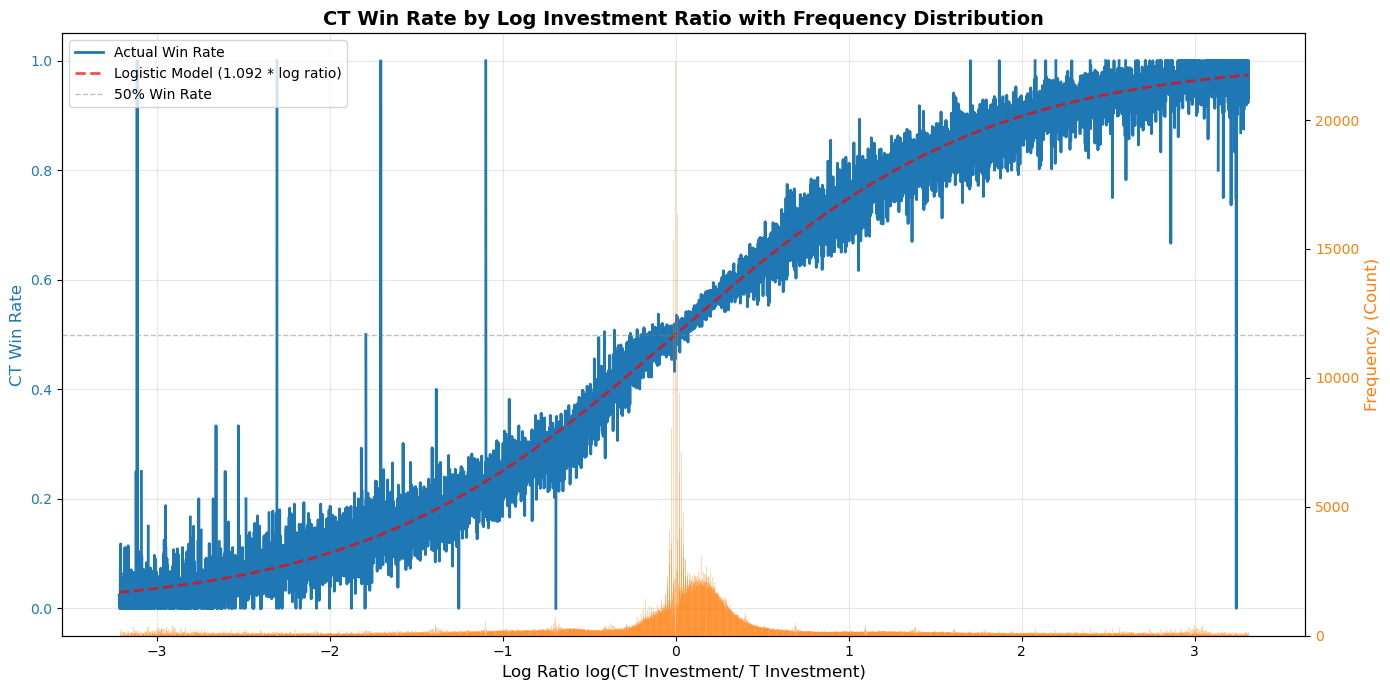

In [ ]:
win_rate_by_investment_3 = df_filtered_ratio.groupby(pd.cut(df_filtered_ratio['ct_t_log_ratio'], bins=10000))['ct_winner'].agg(['mean', 'count'])


fig, ax1 = plt.subplots(figsize=(14, 7))

# Extract midpoints of intervals for proper x-axis values
x_values = [interval.mid for interval in win_rate_by_investment_3.index]

# Calculate theoretical linear relationship using the coefficient from logistic regression
from scipy.special import expit

# Get the coefficient for ct_t_log_ratio from the logistic regression result
log_ratio_coef = result.params['ct_t_log_ratio']
theoretical_win_rate = expit(log_ratio_coef * np.array(x_values))

# Plot win rate on the first y-axis
color = 'tab:blue'
ax1.set_xlabel('Log Ratio log(CT Investment/ T Investment)', fontsize=12)
ax1.set_ylabel('CT Win Rate', color=color, fontsize=12)
ax1.plot(x_values, win_rate_by_investment_3['mean'], color=color, linewidth=2, label='Actual Win Rate')
ax1.plot(x_values, theoretical_win_rate, color='red', linewidth=2, linestyle='--', alpha=0.7, label=f'Logistic Model ({log_ratio_coef:.3f} * log ratio)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='50% Win Rate')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Create second y-axis for frequency
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Frequency (Count)', color=color, fontsize=12)
ax2.bar(x_values, win_rate_by_investment_3['count'], alpha=0.3, color=color, label='Frequency', width=(x_values[1] - x_values[0]) * 0.8)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('CT Win Rate by Log Investment Ratio with Frequency Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
logistic_bin_df = df_filtered_ratio.groupby(pd.cut(df_filtered_ratio['ct_t_log_ratio'], bins=1000))[['ct_winner', 'ct_t_log_ratio']].agg(['mean'])

# Flatten the MultiIndex columns
logistic_bin_df.columns = ['_'.join(col).strip() for col in logistic_bin_df.columns.values]

# Reset index to remove the binned ct_t_log_ratio index
logistic_bin_df = logistic_bin_df.reset_index(drop=True)

# Add continuous number index as first column
logistic_bin_df.insert(0, 'index', range(len(logistic_bin_df)))

# Rename columns to match your desired names
logistic_bin_df.columns = ['index', 'ct_winner_mean', 'ct_t_log_ratio_mean']

logistic_bin_df.head()

,index,ct_winner_mean,ct_t_log_ratio_mean
0,0,0.037859,-3.211343
1,1,0.025332,-3.203931
2,2,0.037815,-3.196740
3,3,0.038000,-3.190357
4,4,0.037500,-3.184156


In [ ]:

x_r = logistic_bin_df['ct_t_log_ratio_mean'].values.reshape(-1, 1)
y = logistic_bin_df['ct_winner_mean'].values

# Split data
xtr_train_3, xtr_test_3, ytr_train_3, ytr_test_3 = train_test_split(x_r, y, test_size=test_size_global, random_state=random_state_global)

# Train dataset
log_model_3 = sm.Logit(ytr_train_3, sm.add_constant(xtr_train_3))
result_3 = log_model_3.fit()
print(result_3.summary())

# test dataset - predict probabilities
yhat_3 = result_3.predict(sm.add_constant(xtr_test_3))



Optimization terminated successfully.
         Current function value: 0.311947
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  700
Model:                          Logit   Df Residuals:                      698
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Feb 2026   Pseudo R-squ.:                  0.5499
Time:                        09:57:53   Log-Likelihood:                -218.36
converged:                       True   LL-Null:                       -485.14
Covariance Type:            nonrobust   LLR p-value:                4.782e-118
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0290      0.103     -0.281      0.778      -0.231       0.173
x1             1.0805      0.

MODEL EVALUATION: BINNED DATA LOGISTIC REGRESSION (1000 bins)

Regression Metrics (Continuous Predictions):
  Test MSE       = 0.000159
  Test RMSE      = 0.012603
  Test MAE       = 0.010007
  Test R²        = 0.998661

Classification Metrics (Rounded Predictions):
  Confusion Matrix : 
 [[145   0]
 [  4 151]]
  Test Accuracy  = 0.9867
  Precision      = 1.0000
  Recall         = 0.9742
  F1-Score       = 0.9869

Probabilistic Metrics:
  AUC-ROC        = 1.0000
  Brier Score    = 0.053732 (lower is better)
  Log Loss       = 0.222108 (lower is better)



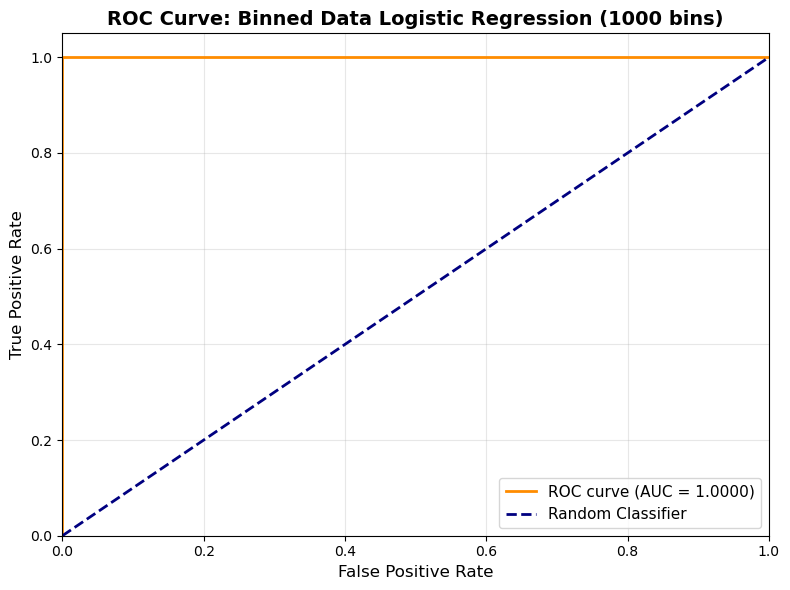

In [ ]:
# Calculate R-squared and MSE for continuous values
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
mse = mean_squared_error(ytr_test_3, yhat_3)
r2 = r2_score(ytr_test_3, yhat_3)
rmse = np.sqrt(mse)
mae = mean_absolute_error(ytr_test_3, yhat_3)

# Since this is continuous prediction on aggregated win rates, we also treat it as classification
prediction_3 = list(map(round, yhat_3))
ytr_test_3_binary = np.array(list(map(round, ytr_test_3)))
cm_3 = confusion_matrix(ytr_test_3_binary, prediction_3)
# For ROC curve, use binary labels with continuous predictions
auc_score_3 = roc_auc_score(ytr_test_3_binary, yhat_3)
fpr_3, tpr_3, _ = roc_curve(ytr_test_3_binary, yhat_3)
brier_score_3 = brier_score_loss(ytr_test_3_binary, yhat_3)
logloss_3 = log_loss(ytr_test_3_binary, yhat_3)
precision_3, recall_3, f1_3, _ = precision_recall_fscore_support(ytr_test_3_binary, prediction_3, average='binary')

print("="*80)
print("MODEL EVALUATION: BINNED DATA LOGISTIC REGRESSION (1000 bins)")
print("="*80)
print()
print('Regression Metrics (Continuous Predictions):')
print(f'  Test MSE       = {mse:.6f}')
print(f'  Test RMSE      = {rmse:.6f}')
print(f'  Test MAE       = {mae:.6f}')
print(f'  Test R²        = {r2:.6f}')
print()
print('Classification Metrics (Rounded Predictions):')
print ("  Confusion Matrix : \n", cm_3)
print(f'  Test Accuracy  = {accuracy_score(ytr_test_3_binary, prediction_3):.4f}')
print(f'  Precision      = {precision_3:.4f}')
print(f'  Recall         = {recall_3:.4f}')
print(f'  F1-Score       = {f1_3:.4f}')
print()
print('Probabilistic Metrics:')
print(f'  AUC-ROC        = {auc_score_3:.4f}')
print(f'  Brier Score    = {brier_score_3:.6f} (lower is better)')
print(f'  Log Loss       = {logloss_3:.6f} (lower is better)')
print()

# Plot ROC Curve
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr_3, tpr_3, color='darkorange', linewidth=2, label=f'ROC curve (AUC = {auc_score_3:.4f})')
ax.plot([0, 1], [0, 1], color='navy', linewidth=2, linestyle='--', label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve: Binned Data Logistic Regression (1000 bins)', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

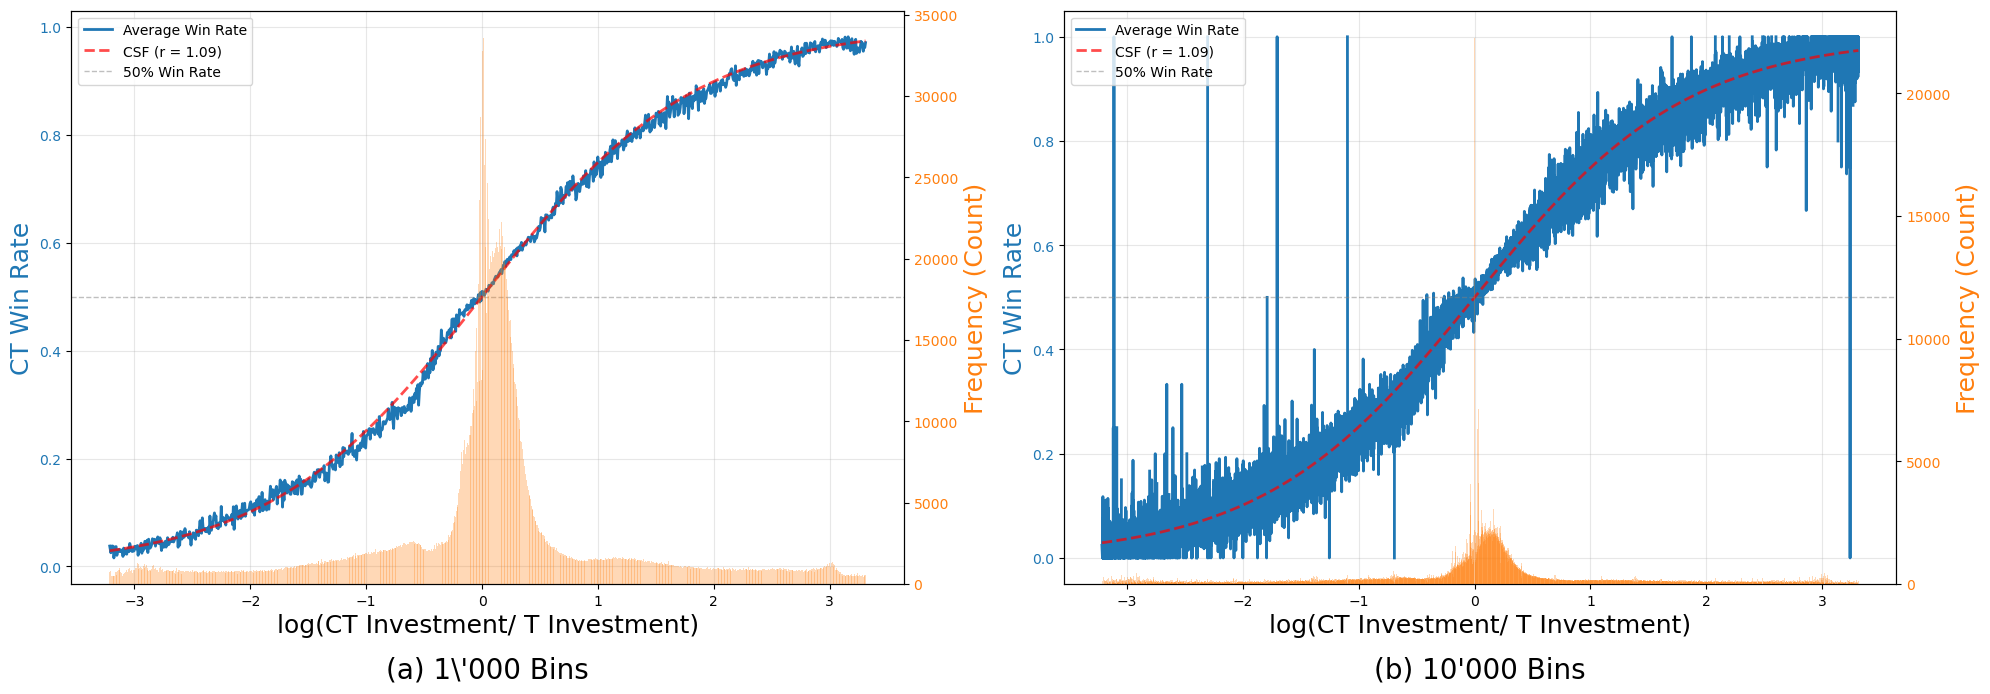

In [ ]:
# ============================================================================
# COMBINED VISUALIZATION: CT WIN RATE BY LOG RATIO (1000 vs 10,000 bins)
# ============================================================================

# Aggregate data for 1000 bins
win_rate_by_investment_1000 = df_filtered_ratio.groupby(pd.cut(df_filtered_ratio['ct_t_log_ratio'], bins=1000))['ct_winner'].agg(['mean', 'count'])

fig, (ax1_left, ax1_right) = plt.subplots(1, 2, figsize=(20, 7))

# ============================================================================
# LEFT SUBPLOT: 1000 BINS
# ============================================================================

# Extract midpoints of intervals for proper x-axis values
x_values_1000 = [interval.mid for interval in win_rate_by_investment_1000.index]

# Calculate theoretical linear relationship using the coefficient from logistic regression
log_ratio_coef = r_optimal
theoretical_win_rate_1000 = expit(log_ratio_coef * np.array(x_values_1000))

# Plot win rate on the first y-axis
color = 'tab:blue'
ax1_left.set_xlabel('log(CT Investment/ T Investment)', fontsize=18)
ax1_left.set_ylabel('CT Win Rate', color=color, fontsize=18)
ax1_left.plot(x_values_1000, win_rate_by_investment_1000['mean'], color=color, linewidth=2, label='Average Win Rate')
ax1_left.plot(x_values_1000, theoretical_win_rate_1000, color='red', linewidth=2, linestyle='--', alpha=0.7, label=f'CSF (r = {log_ratio_coef:.2f})')
ax1_left.tick_params(axis='y', labelcolor=color)
ax1_left.axhline(0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='50% Win Rate')
ax1_left.legend(loc='upper left')
ax1_left.grid(alpha=0.3)


ax1_left.text(0.5, -0.15, r'(a) 1\'000 Bins', transform=ax1_left.transAxes, fontsize=20, va='center', ha='center')

# Create second y-axis for frequency
ax2_left = ax1_left.twinx()
color = 'tab:orange'
ax2_left.set_ylabel('Frequency (Count)', color=color, fontsize=18)
ax2_left.bar(x_values_1000, win_rate_by_investment_1000['count'], alpha=0.3, color=color, label='Frequency', width=(x_values_1000[1] - x_values_1000[0]) * 0.8)
ax2_left.tick_params(axis='y', labelcolor=color)



# ============================================================================
# RIGHT SUBPLOT: 10,000 BINS
# ============================================================================

# Extract midpoints of intervals for proper x-axis values
x_values_10000 = [interval.mid for interval in win_rate_by_investment_3.index]

# Calculate theoretical linear relationship using the coefficient from logistic regression
theoretical_win_rate_10000 = expit(log_ratio_coef * np.array(x_values_10000))

# Plot win rate on the first y-axis
color = 'tab:blue'
ax1_right.set_xlabel('log(CT Investment/ T Investment)', fontsize=18)
ax1_right.set_ylabel('CT Win Rate', color=color, fontsize=18)
ax1_right.plot(x_values_10000, win_rate_by_investment_3['mean'], color=color, linewidth=2, label='Average Win Rate')
ax1_right.plot(x_values_10000, theoretical_win_rate_10000, color='red', linewidth=2, linestyle='--', alpha=0.7, label=f'CSF (r = {log_ratio_coef:.2f})')
ax1_right.tick_params(axis='y', labelcolor=color)
ax1_right.axhline(0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='50% Win Rate')
ax1_right.legend(loc='upper left')
ax1_right.grid(alpha=0.3)

ax1_right.text(0.5, -0.15, '(b) 10\'000 Bins', transform=ax1_right.transAxes, fontsize=20, va='center', ha='center')

# Create second y-axis for frequency
ax2_right = ax1_right.twinx()
color = 'tab:orange'
ax2_right.set_ylabel('Frequency (Count)', color=color, fontsize=18)
ax2_right.bar(x_values_10000, win_rate_by_investment_3['count'], alpha=0.3, color=color, label='Frequency', width=(x_values_10000[1] - x_values_10000[0]) * 0.8)
ax2_right.tick_params(axis='y', labelcolor=color)



# ============================================================================
plt.tight_layout()
plt.show()